In [1]:
import os
import json
import pandas as pd
import numpy as np
import json

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, LogFormatterExponent, ScalarFormatter
import seaborn as sb

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
sb.set_style("darkgrid")
sb.set_context("paper",  font_scale = 1,
               rc={
                   "grid.linewidth": 3.75,
                   'axes.labelsize': 28,
                   "axes.titlesize": 32,
                   "legend.fontsize": 28.0,
                   'lines.linewidth': 5,
                   'xtick.labelsize': 24.0,
                   'ytick.labelsize': 24.0,
               })
current_palette = list(sb.color_palette())
colors = {
    'RL': current_palette[0],
    'RR': current_palette[5],
    'SOP':current_palette[4],
    'RAND':current_palette[7],
    'optimal':current_palette[1],
    '0':current_palette[-2],
    '1':current_palette[-1]
}

In [3]:
def plot(plot_bsf=True, old=False, lay=[5, 10, 20], uni=[20, 40], exp=[1, 2], splits=[1],
         local=False, assembly_version=2, log=True):
    assembly = 'assembly_v%d' % assembly_version
    for split in splits:
        for units in uni:
            for layers in lay:

                fig = plt.figure(figsize=(15, 5), dpi=100)
                ax = plt.gca()
                for exploration in exp:
                    if local:
                        exp_dir = os.path.join(os.path.sep, 'home', 'biedenka', 'git',
                                               'rl-plan', 'experiments', assembly,
                                               'old_feats_wide_long_%d_full_train_set_%d-%d-%d-split%d' % (
                                                   split, layers, units, exploration, split))
                    else:
                        exp_dir = os.path.join(os.path.sep, 'mhome', 'biedenka',
                                               'rl-plan-tmp', 'experiments', assembly,
                                               'old_feats_wide_long_%d_full_train_set_%d-%d-%d-split%d' % (
                                                   split, layers, units, exploration, split))
                    if exploration == 1:
                        print('#'*80)
                        print(exp_dir)
                        print('#'*80)
                    try:
                        df = pd.read_csv(os.path.join(exp_dir, 'scores.txt'), sep='\t',
                                         index_col=None)
                    except Exception as e:
                        print(e)

                    if not plot_bsf:
                        plt.step(df.steps, df['mean'] * -1, where='mid', label='mean',
                                 alpha=0.25)
                        # plt.step(df.steps, df['min'] * -1, where='mid', label='worst')
                        plt.step(df.steps, df['median'] * -1, where='mid', label='median',
                                 alpha=0.25)
                        plt.xlabel('#steps')
                    else:
                        mean = df['mean']
                        mead = df['median']
                        me, md = [], []
                        for idx, v in enumerate(zip(mean, mead)):
                            if idx == 0: 
                                me.append(v[0])
                                md.append(v[1])
                                continue
                            if v[0] > me[-1]:
                                me.append(mean[idx])
                                md.append(mead[idx])
                            else:
                                me.append(me[-1])
                                md.append(md[-1])
                        # additional +1 as reward is misaligned by 1
                        data = np.array(me) * -1
                        plt.step(df.steps/1000, (np.array(me) +1) * -1, where='post')  # ,
    #                              label='learned-bsf')
                        try:
                            print('Final learned', data[-1])
                        except:
                            pass
                        #  plt.step(df.steps/1000, np.array(md) * -1, where='post',
                        #           label='median-bsf')

                ax.set_title('TRAIN')
                ax.set_ylabel('RL-Cost')
                y_lim = [0, 7_500] if not log else [50, 7_500]
                if plot_bsf:
                    plt.ylim(y_lim)
                    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                              fancybox=True, shadow=True, ncol=4)
                    plt.xlabel('#steps [k]')
#                     plt.xlim([0, 1_000])
                else:
                    plt.ylim(y_lim)
#                     plt.xlim([0, 1_000_000])
                    plt.xlabel('#steps')
                if log:
                    plt.semilogy()
                plt.show()
                print()
                print()

In [4]:
def plot_means(plot_bsf=True, old=False, lay=[5, 10, 20], uni=[20, 40], exp=[1, 2],
               quantile=False, splits=[1], medi=False, local=False, assembly_version=2,
               log=True):
    assembly = 'assembly_v%d' % assembly_version
    for split in splits:
        for units in uni:
            for layers in lay:

                fig = plt.figure(figsize=(15, 5), dpi=100)
                ax = plt.gca()
                dfs = []
                for exploration in exp:
                    if local:
                        exp_dir = os.path.join(os.path.sep, 'home', 'biedenka', 'git',
                                               'rl-plan', 'experiments', assembly,
                                               'old_feats_wide_long_%d_full_train_set_%d-%d-%d-split%d' % (
                                                   split, layers, units, exploration, split))
                    else:
                        exp_dir = os.path.join(os.path.sep, 'mhome', 'biedenka',
                                               'rl-plan-tmp', 'experiments', assembly,
                                               'old_feats_wide_long_%d_full_train_set_%d-%d-%d-split%d' % (
                                                   split, layers, units, exploration, split))
                    if exploration == 1:
                        print('#'*80)
                        print(exp_dir)
                        print('#'*80)
                    try:
                        df = pd.read_csv(os.path.join(exp_dir, 'scores.txt'), sep='\t',
                                         index_col=None)
                        if not df.empty:
                            dfs.append(df)
                    except Exception as e:
                        print(e)

                if not plot_bsf:
                    frame = pd.concat(dfs)
                    if quantile:
                        df = frame.groupby(frame.index).quantile(q=.5)
                        dsu = frame.groupby(frame.index).quantile(q=.75)
                        dsl = frame.groupby(frame.index).quantile(q=.25)
                        u = dsl['mean'] * -1
                        l = dsu['mean'] * -1
                        um = dsl['median'] * -1
                        lm = dsu['median'] * -1
                    else:
                        df = frame.groupby(frame.index).mean()
                        ds = frame.groupby(frame.index).std()
                        u = df['mean'] * -1 + ds['mean']
                        l = df['mean'] * -1 - ds['mean']
                        um = df['median'] * -1 + ds['median']
                        lm = df['median'] * -1 - ds['median']
                    plt.step(df.steps, df['mean'] * -1, where='post',
                             label='mean', color='b')
                    plt.fill_between(df.steps, u, l, step='post', color='b', alpha=0.25)
                    if medi:
                        plt.step(df.steps, df['median'] * -1, where='post',
                                 label='median', color='orange')
                        plt.fill_between(df.steps, um, lm, step='post', color='orange', alpha=0.25)
                    plt.xlabel('#steps')
                else:
                    mes = []
                    stps = []
                    ml = -1
                    for df in dfs:
                        mean = df['mean']
                        mead = df['median']
                        steps = df['steps']
                        me, md = [], []
                        stp = []
                        for idx, v in enumerate(zip(mean, mead, steps)):
                            if idx == 0: 
                                me.append(v[0])
                                md.append(v[1])
                                stp.append(v[2])
                                continue
                            if v[0] > me[-1]:
                                me.append(mean[idx])
                                md.append(mead[idx])
                                stp.append(steps[idx])
                            else:
                                me.append(me[-1])
                                md.append(md[-1])
                                stp.append(steps[idx])
                        if len(me) > ml:
                            ml = len(me)
                        mes.append(me)
                        stps.append(stp)
                    for idx in range(len(mes)):
                        while len(mes[idx]) < ml:
                            mes[idx].append(np.nan)
                            stps[idx].append(np.nan)

                    if quantile:
                        m = -np.nanquantile(mes, q=.5, axis=0)
                        u = -np.nanquantile(mes, q=.25, axis=0)
                        l = -np.nanquantile(mes, q=.75, axis=0)
                    else:
                        m = -np.nanmean(mes, axis=0)
                        u = m + np.nanstd(mes, axis=0)
                        l = m - np.nanstd(mes, axis=0)
                    stps = np.nanmean(stps, axis=0) / 1000
                    plt.step(stps, m, where='post',
                             label='learned-bsf')

                    plt.fill_between(stps, u, l, step='post', color='b', alpha=0.25)
                    print('Final learned', m[-1])
                    #  plt.step(df.steps/1000, np.array(md) * -1, where='post',
                    #           label='median-bsf')

                ax.set_title('TRAIN')
                ax.set_ylabel('RL-Cost')
                y_lim = [0, 7_500] if not log else [50, 7_500]
                if plot_bsf:
                    plt.ylim(y_lim)
                    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                              fancybox=True, shadow=True, ncol=4)
                    plt.xlabel('#steps [k]')
                    plt.xlim([0, 1_000])
                else:
                    plt.ylim(y_lim)
                    plt.xlim([0, 1_000_000])
                    plt.xlabel('#steps')
                if log:
                    plt.semilogy()
                plt.show()
                print()
                print()
        print('~'*80)
        print('+'*80)
        print('~'*80)

In [5]:
def plot_mean_of_cv(plot_bsf=True, old=False, lay=[5, 10, 20], uni=[20, 40], exp=[1, 2],
                    quantile=False, splits=[1], medi=False, local=False, assembly_version=2,
                    log=True):
    assembly = 'assembly_v%d' % assembly_version
    for units in uni:
        for layers in lay:

            fig = plt.figure(figsize=(15, 5), dpi=100)
            ax = plt.gca()
            dfs = []
            for split in splits:
                for exploration in exp:
                    if local:
                        exp_dir = os.path.join(os.path.sep, 'home', 'biedenka', 'git',
                                               'rl-plan', 'experiments', assembly,
                                               'old_feats_wide_long_%d_full_train_set_%d-%d-%d-split%d' % (
                                                   split, layers, units, exploration, split))
                    else:
                        exp_dir = os.path.join(os.path.sep, 'mhome', 'biedenka',
                                               'rl-plan-tmp', 'experiments', assembly,
                                               'old_feats_wide_long_%d_full_train_set_%d-%d-%d-split%d' % (
                                                   split, layers, units, exploration, split))
                    if exploration == 1 and split == 1:
                        print('#'*80)
                        print(exp_dir)
                        print('#'*80)
                    try:
                        df = pd.read_csv(os.path.join(exp_dir, 'scores.txt'), sep='\t',
                                         index_col=None)
                        if not df.empty:
                            dfs.append(df)
                    except Exception as e:
                        print(e)

            if not plot_bsf:
                frame = pd.concat(dfs)
                if quantile:
                    df = frame.groupby(frame.index).quantile(q=.5)
                    dsu = frame.groupby(frame.index).quantile(q=.75)
                    dsl = frame.groupby(frame.index).quantile(q=.25)
                    u = dsl['mean'] * -1
                    l = dsu['mean'] * -1
                    um = dsl['median'] * -1
                    lm = dsu['median'] * -1
                else:
                    df = frame.groupby(frame.index).mean()
                    ds = frame.groupby(frame.index).std()
                    u = df['mean'] * -1 + ds['mean']
                    l = df['mean'] * -1 - ds['mean']
                    um = df['median'] * -1 + ds['median']
                    lm = df['median'] * -1 - ds['median']
                plt.step(df.steps, df['mean'] * -1, where='post',
                         label='mean',
                         color=colors['RL'])
                plt.fill_between(df.steps, u, l, step='post',
                                 color=colors['RL'], alpha=0.25)
                if medi:
                    plt.step(df.steps, df['median'] * -1, where='post',
                             label='median',
                             color=colors['RL'])
                    plt.fill_between(df.steps, um, lm, step='post', color='orange', alpha=0.25)
                plt.xlabel('#steps')
            else:
                mes = []
                stps = []
                ml = -1
                for df in dfs:
                    mean = df['mean']
                    mead = df['median']
                    steps = df['steps']
                    me, md = [], []
                    stp = []
                    for idx, v in enumerate(zip(mean, mead, steps)):
                        if idx == 0: 
                            me.append(v[0])
                            md.append(v[1])
                            stp.append(v[2])
                            continue
                        if v[0] > me[-1]:
                            me.append(mean[idx])
                            md.append(mead[idx])
                            stp.append(steps[idx])
                        else:
                            me.append(me[-1])
                            md.append(md[-1])
                            stp.append(steps[idx])
                    if len(me) > ml:
                        ml = len(me)
                    mes.append(me)
                    stps.append(stp)
                for idx in range(len(mes)):
                    while len(mes[idx]) < ml:
                        mes[idx].append(mes[idx][-1])
                        stps[idx].append(np.nan)

                if quantile:
                    m = -np.nanquantile(mes, q=.5, axis=0)
                    u = -np.nanquantile(mes, q=.25, axis=0)
                    l = -np.nanquantile(mes, q=.75, axis=0)
                else:
                    m = -np.nanmean(mes, axis=0)
                    u = m + np.nanstd(mes, axis=0)
                    l = m - np.nanstd(mes, axis=0)
                stps = np.nanmean(stps, axis=0)
                plt.step(stps, m, where='post',
                         label='RL')

                plt.fill_between(stps, u, l, step='post',
                                 color=colors['RL'], alpha=0.25)
                print('Final learned', m[-1])
                #  plt.step(df.steps/1000, np.array(md) * -1, where='post',
                #           label='median-bsf')432.86599999999993
                plt.plot(stps, [388.76666666666665 for stp in stps],
                         ls='--',
                         color=colors['RR'], label='RR')
                plt.plot(stps, [432.86599999999993 for stp in stps],
                         ls='--',
                         color=colors['RAND'], label='RAND')

            ax.set_ylabel('RL-Cost')
            y_lim = [0, 7_500] if not log else [50, 7_500]
            if plot_bsf:
                ax.set_title('Incumbent Performance on Assembly Training Set')
                plt.ylim(y_lim)
                ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
                          fancybox=True, shadow=True, ncol=4)
                plt.xlabel('#steps')
                plt.xlim([0, 1_000_000])
            else:
                ax.set_title('Performance on Training Set')
                plt.ylim(y_lim)
                plt.xlim([0, 1_000_000])
                plt.xlabel('#steps')
            if log:
                plt.semilogy()
            ax.get_xaxis().set_major_formatter(
            FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.savefig(
                'assembly_mean_over_10_runs_{:s}_layer_{:d}_'\
                'units_{:d}_state_2.pdf'.format(
            'bsf' if plot_bsf else 'traj', layers, units), bbox_inches='tight')
            plt.show()
            print()
            print()
        print('~'*80)
        print('+'*80)
        print('~'*80)

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
# Results over 10 seeds
## Plotting 5fold-CV-result

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-75-1-split1
################################################################################
Final learned 323.66666666666663


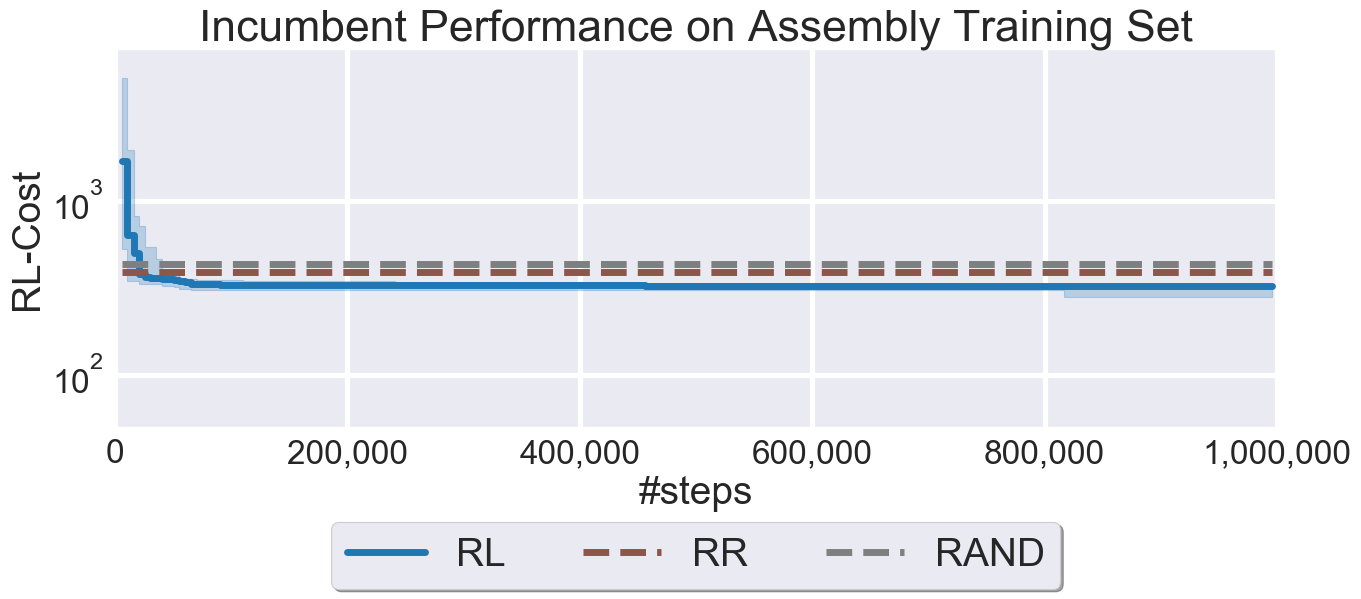



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-200-1-split1
################################################################################
Final learned 316.29166666666663


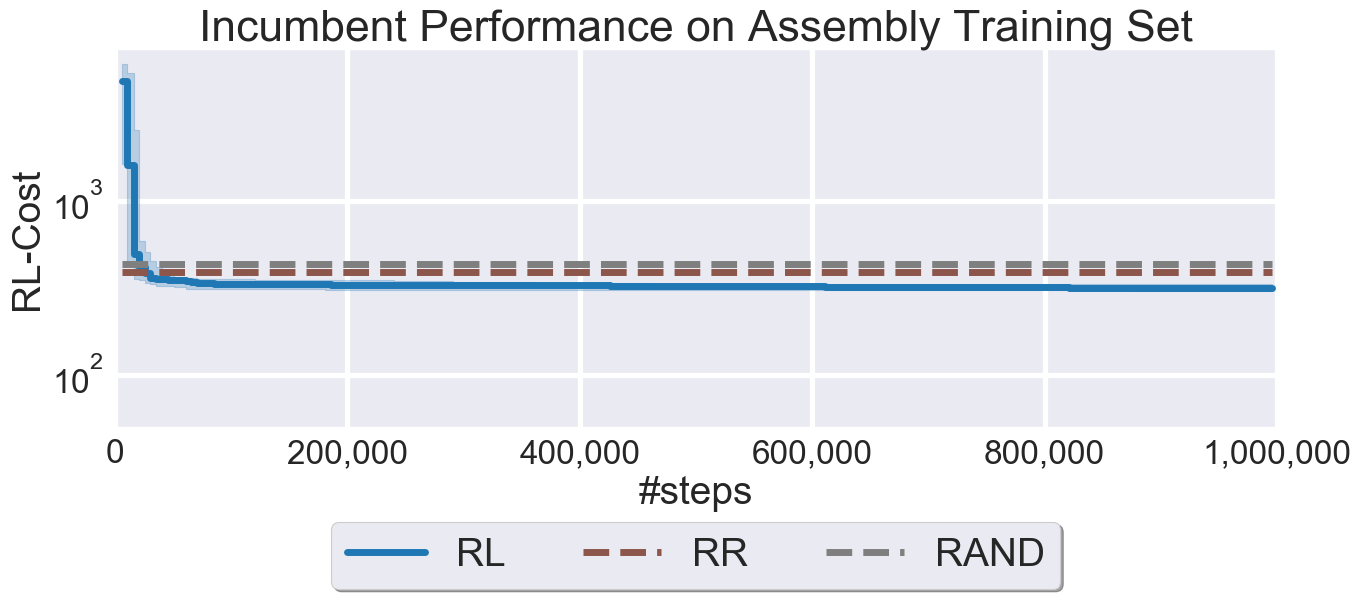



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [6]:
plot_mean_of_cv(plot_bsf=True, old=True, lay=[2], uni=[75, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=True,
           splits=[1,2,3,4,5], local=False, assembly_version=3)

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-75-1-split1
################################################################################


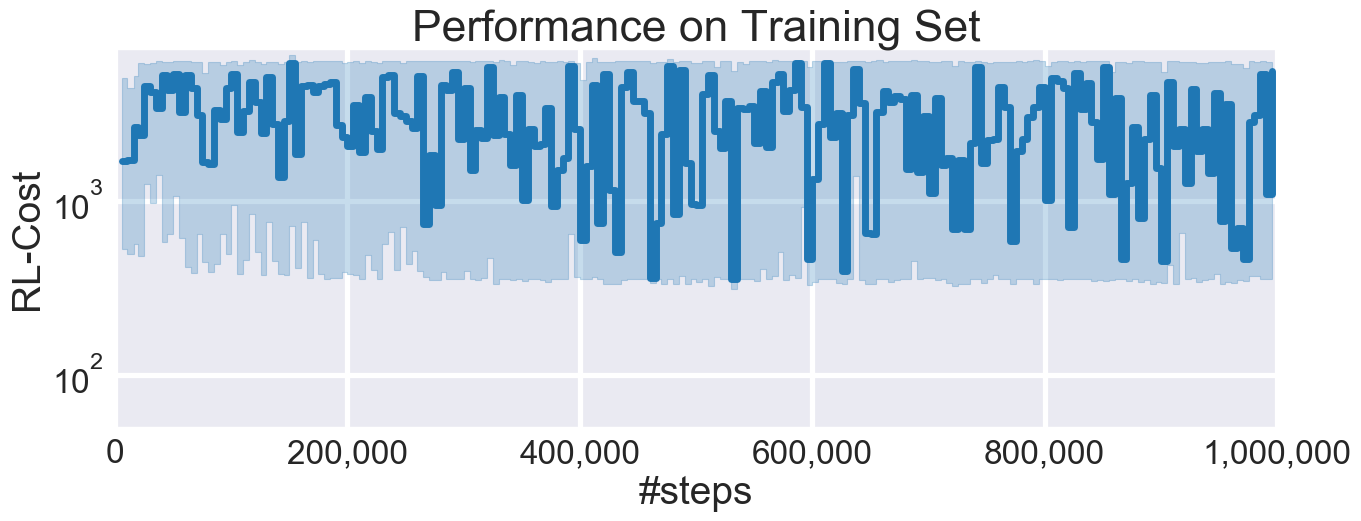



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-200-1-split1
################################################################################


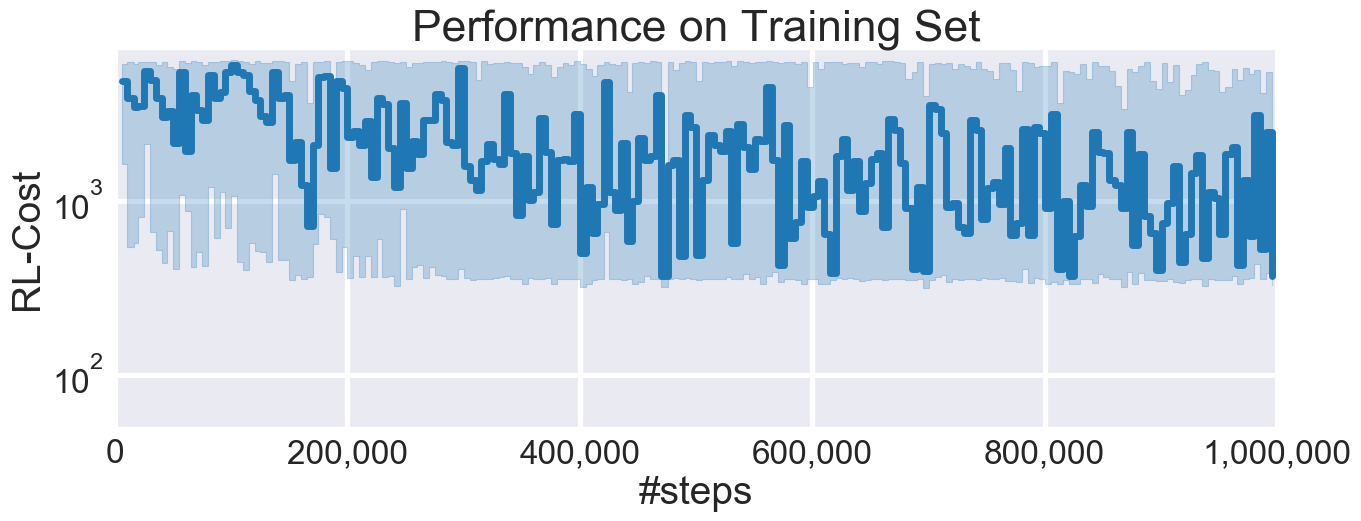



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [7]:
plot_mean_of_cv(plot_bsf=False, old=True, lay=[2], uni=[75, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=True,
           splits=[1,2,3,4,5], local=False, assembly_version=3)

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
# Results over 10 seeds
## Plotting individual splits

#### Plot Incumbent Performance

##### Plots using mean +- stdev
plot_means(plot_bsf=True, old=True, lay=[2], uni=[75, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=False)
           
           
           
##### Plots using Quartiles:           

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-75-1-split1
################################################################################
Final learned 325.375


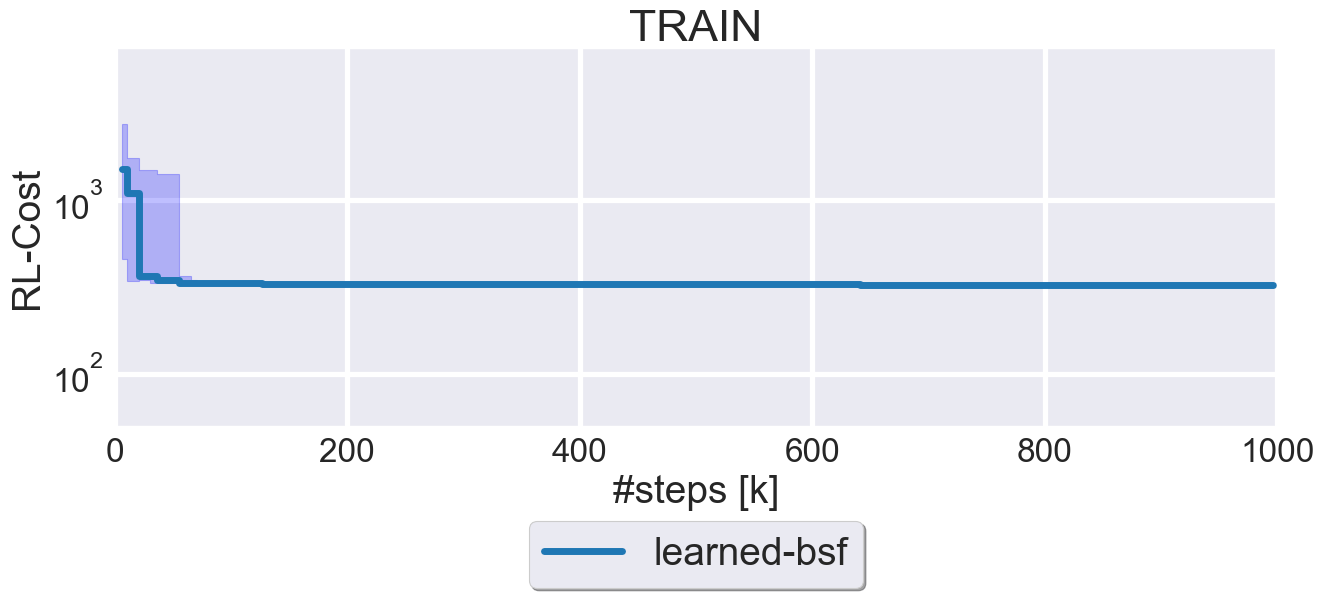



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-200-1-split1
################################################################################
Final learned 314.77083333333337


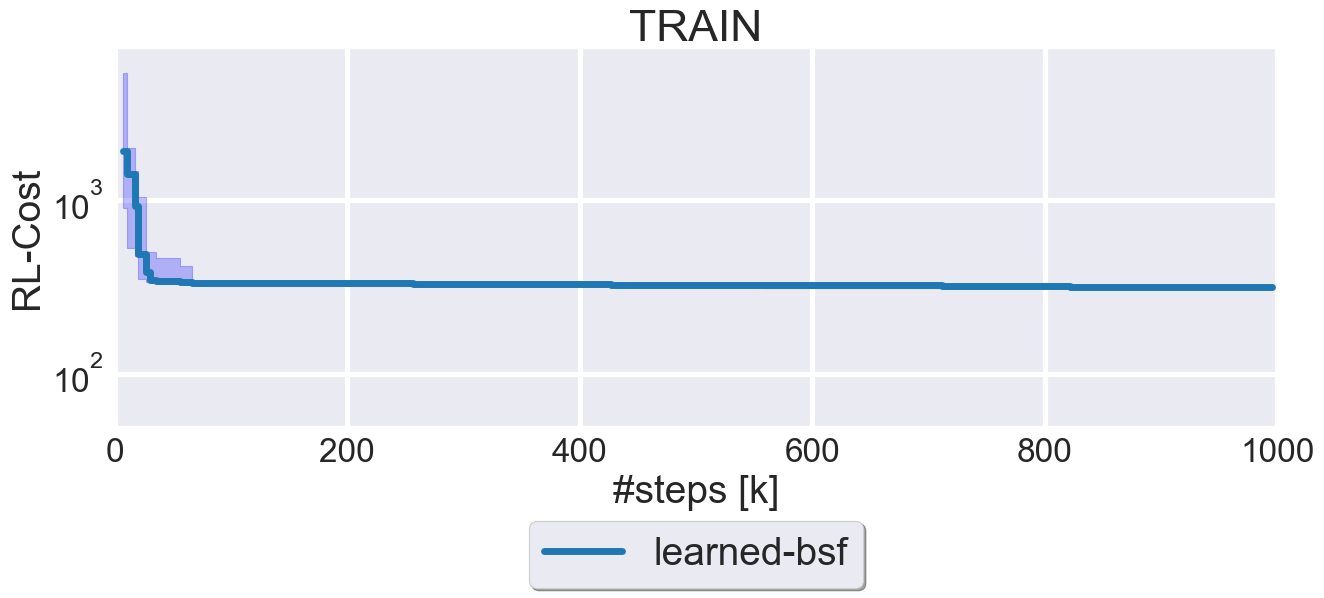



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_2_full_train_set_2-75-1-split2
################################################################################
Final learned 172.95833333333337


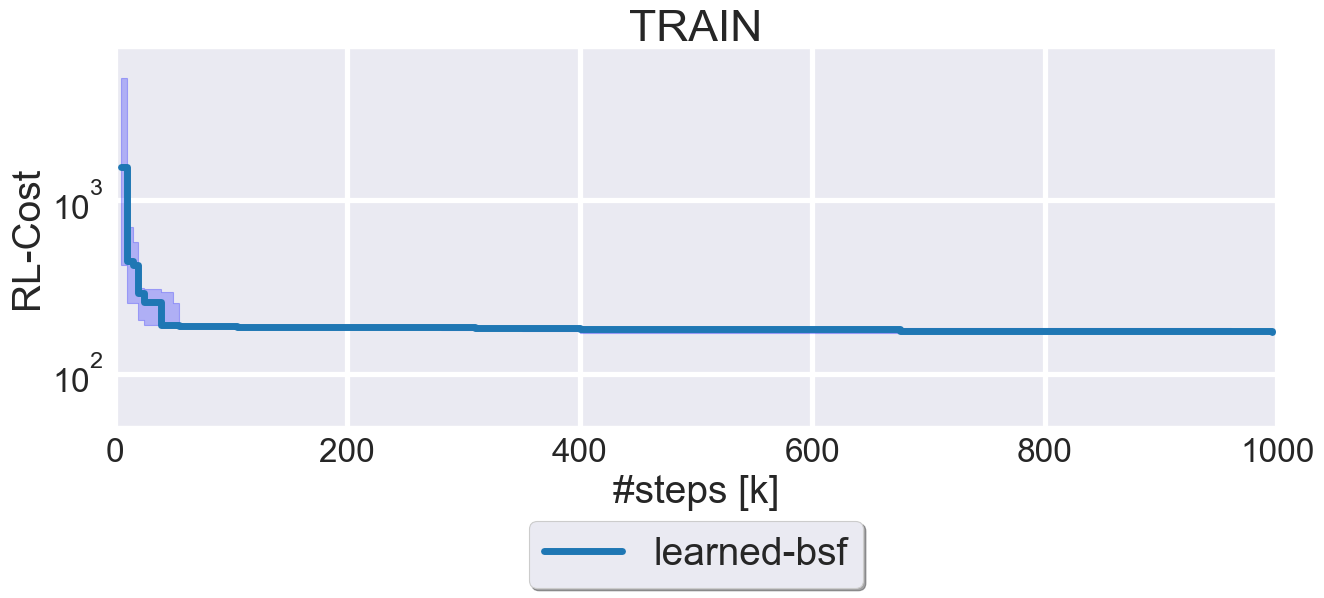



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_2_full_train_set_2-200-1-split2
################################################################################
Final learned 169.45833333333334


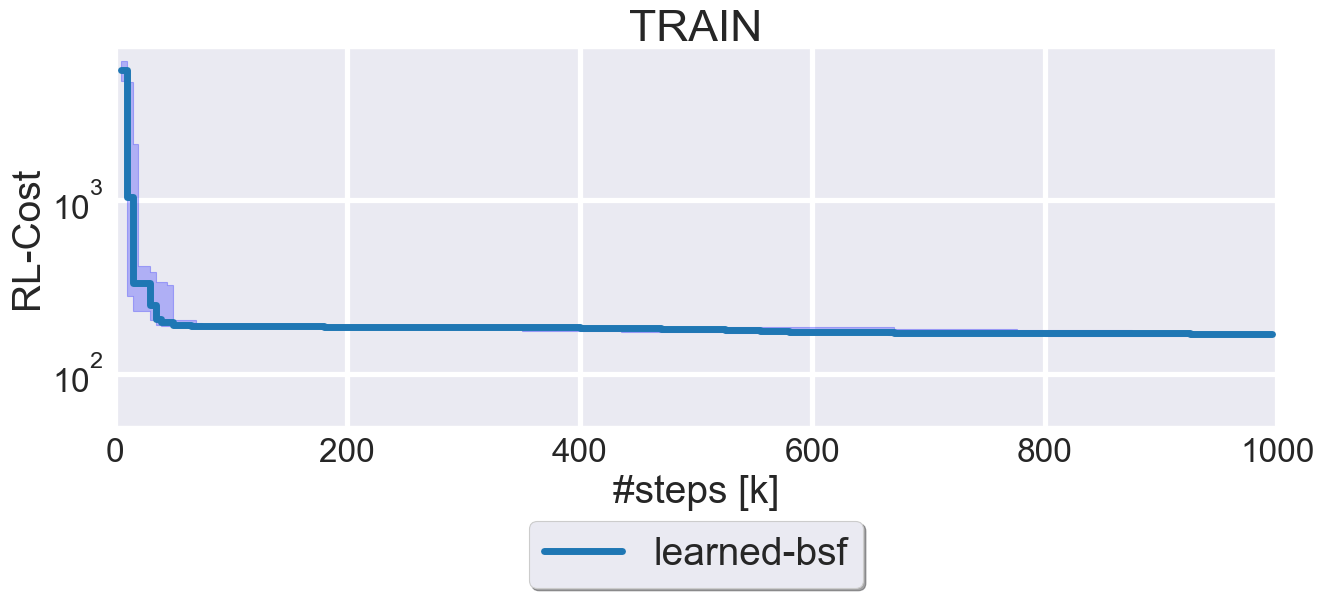



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_3_full_train_set_2-75-1-split3
################################################################################
Final learned 346.39583333333337


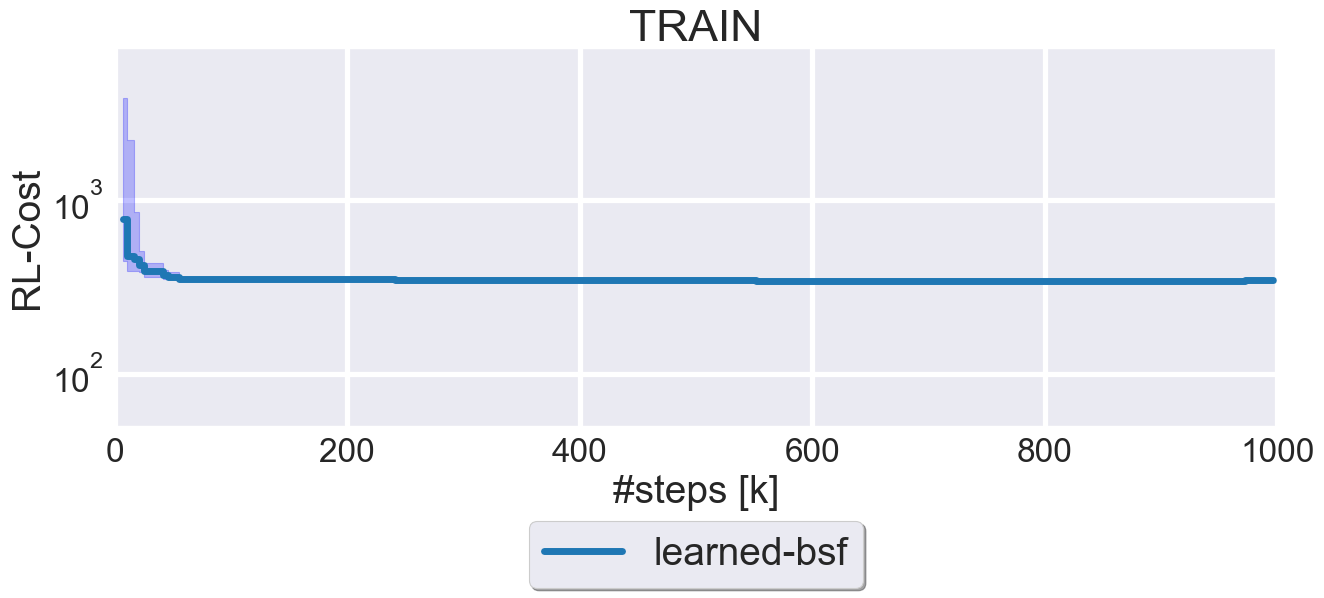



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_3_full_train_set_2-200-1-split3
################################################################################
Final learned 340.8958333333333


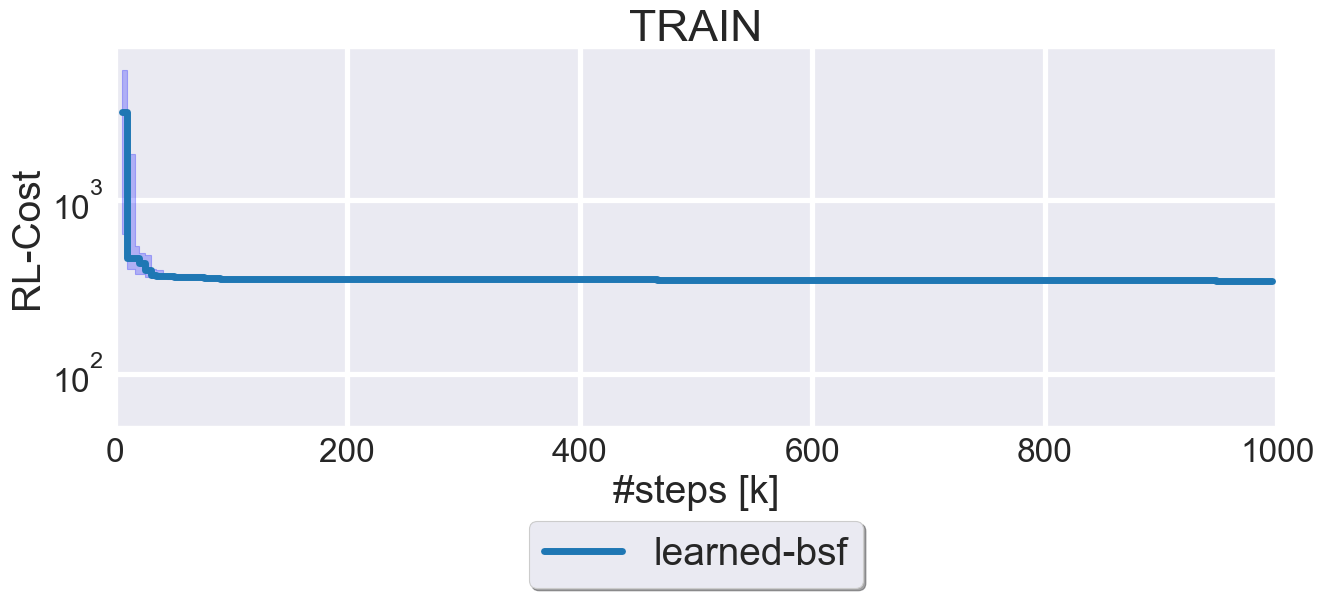



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_4_full_train_set_2-75-1-split4
################################################################################
Final learned 331.77083333333337


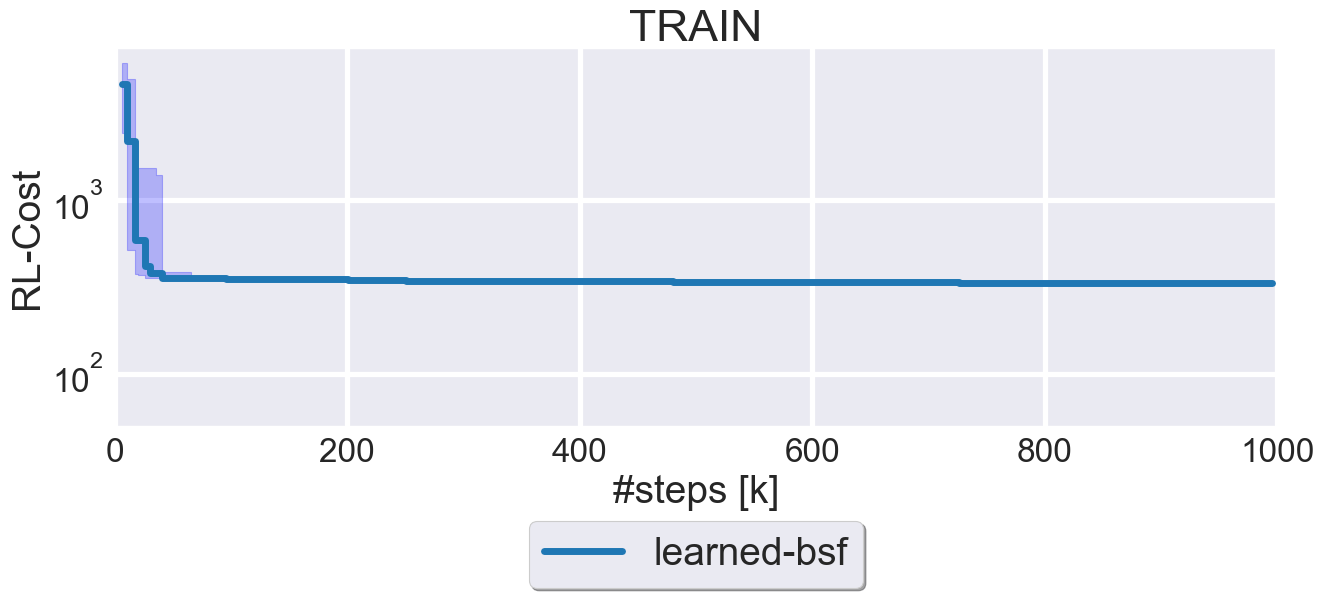



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_4_full_train_set_2-200-1-split4
################################################################################
Final learned 331.5833333333333


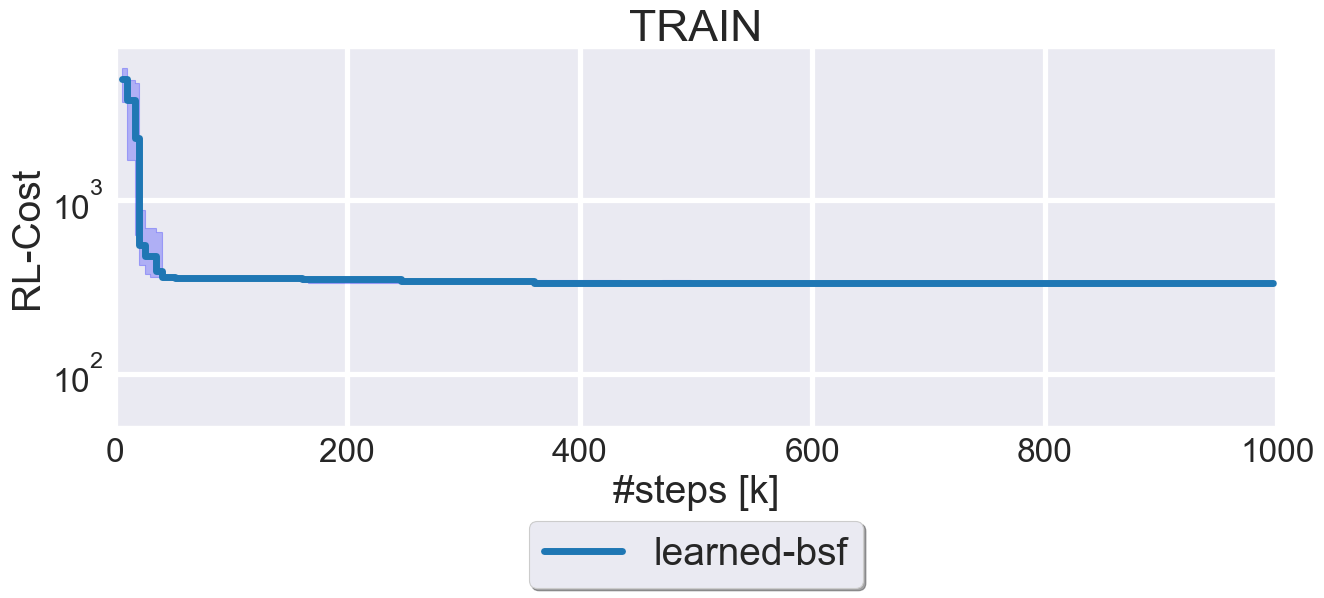



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_5_full_train_set_2-75-1-split5
################################################################################
Final learned 308.25


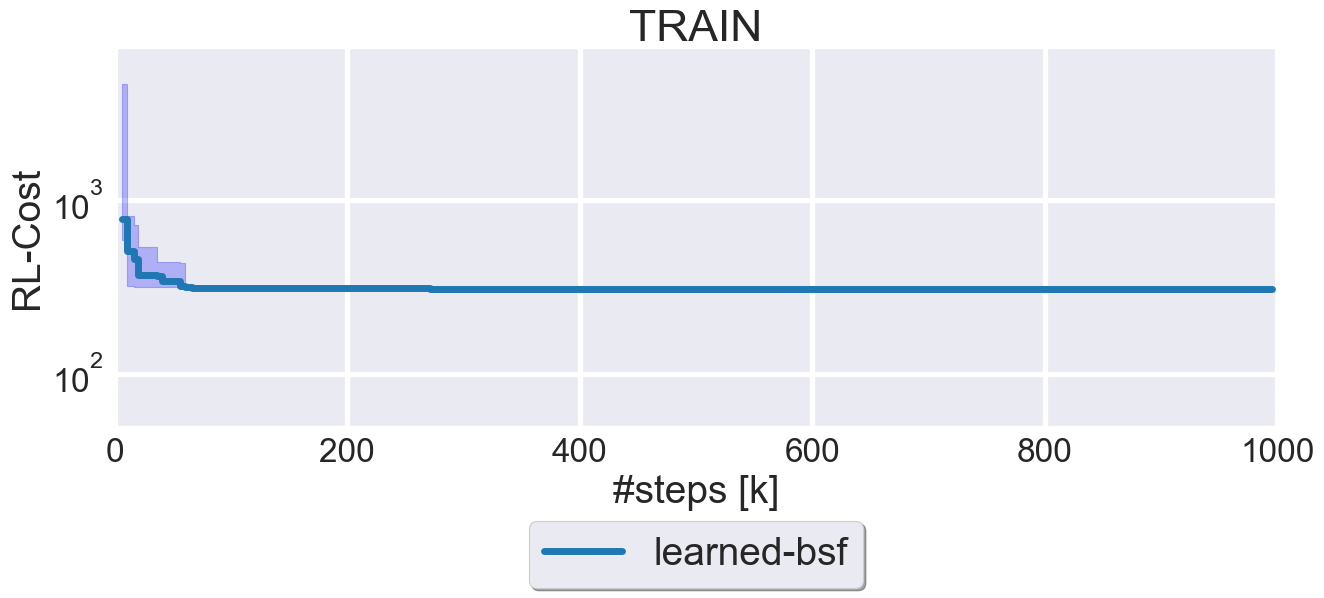



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_5_full_train_set_2-200-1-split5
################################################################################
Final learned 307.16666666666663


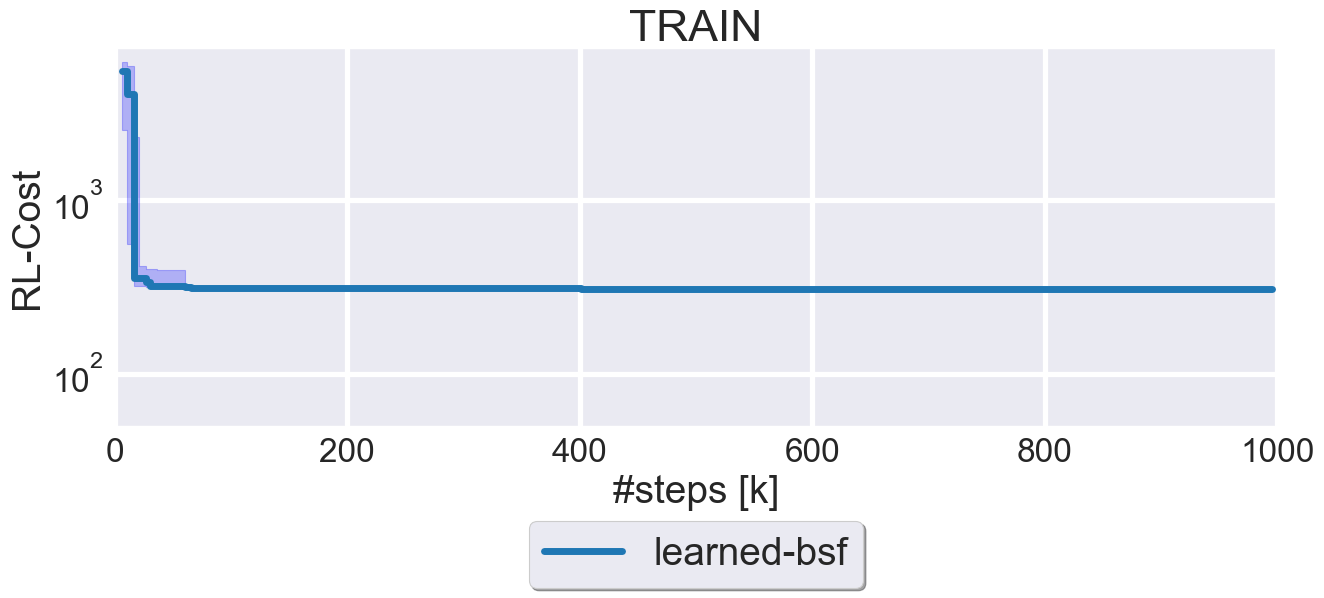



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [8]:
plot_means(plot_bsf=True, old=True, lay=[2], uni=[75, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=True,
           splits=[1,2,3,4,5], local=False, assembly_version=3)

#### Plot RL Performance

##### Plots using mean +- stdev
plot_means(plot_bsf=False, old=True, lay=[2], uni=[75, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=False)
           
           
           
##### Plots using Quartiles:           

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-75-1-split1
################################################################################


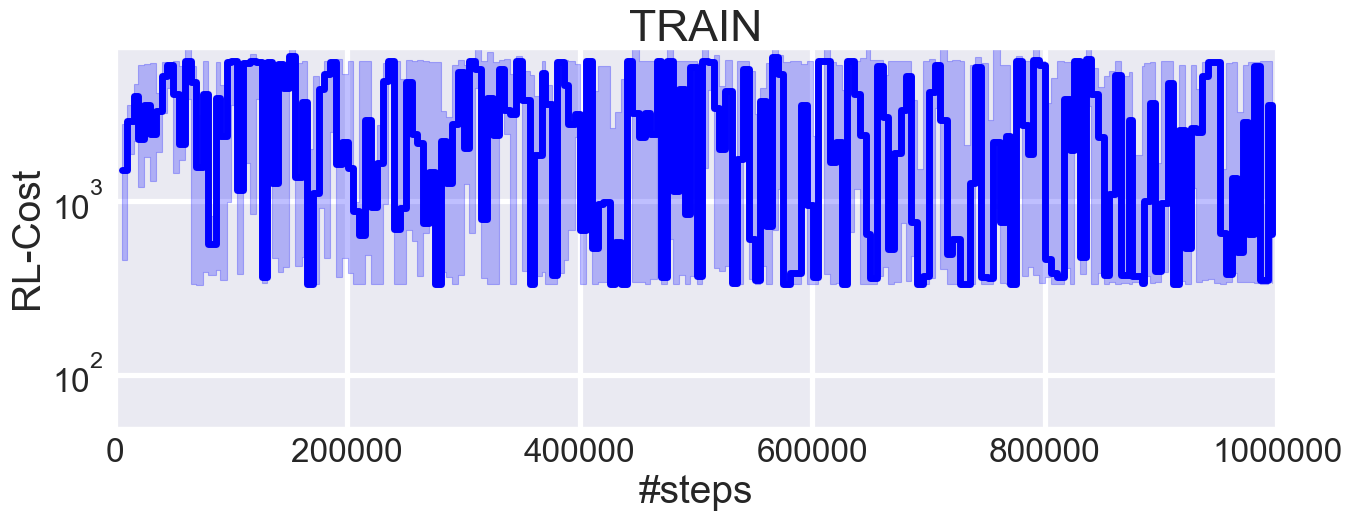



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-200-1-split1
################################################################################


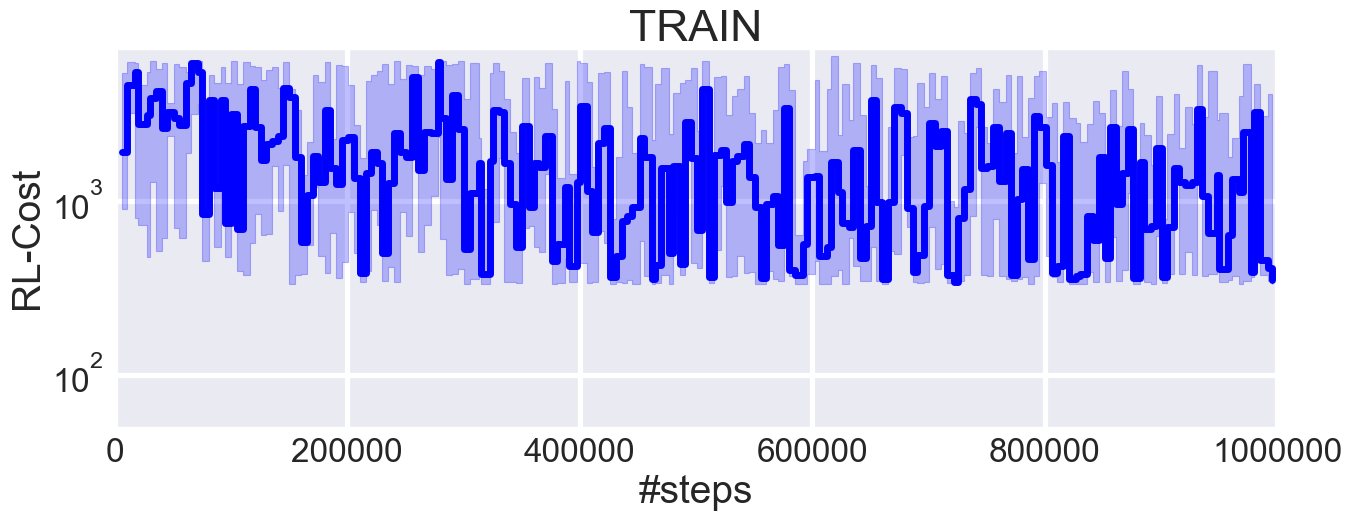



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_2_full_train_set_2-75-1-split2
################################################################################


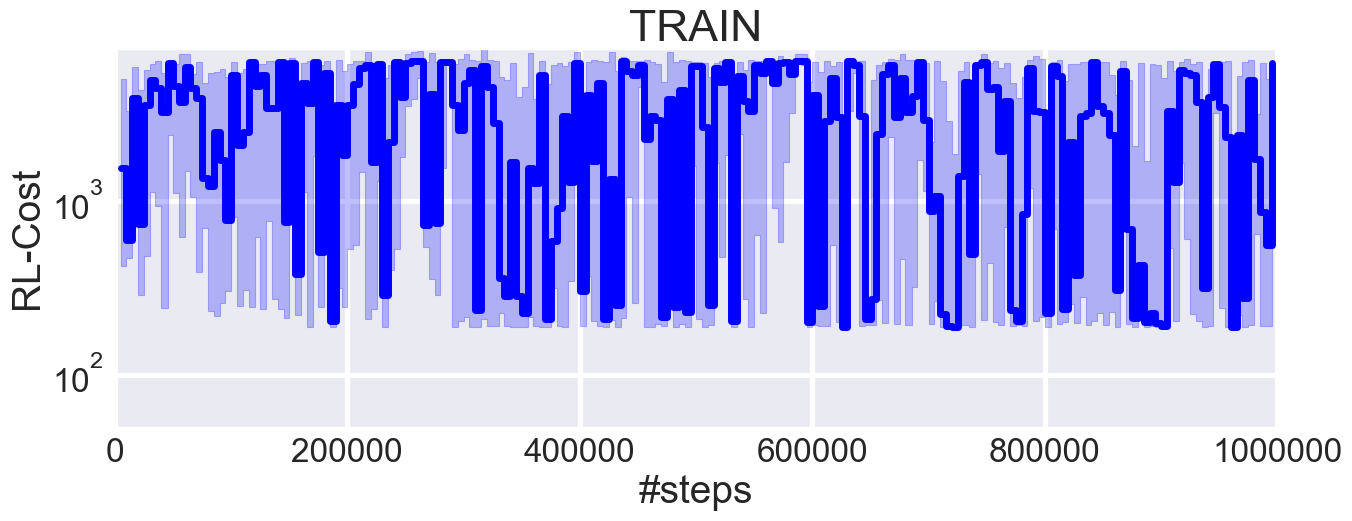



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_2_full_train_set_2-200-1-split2
################################################################################


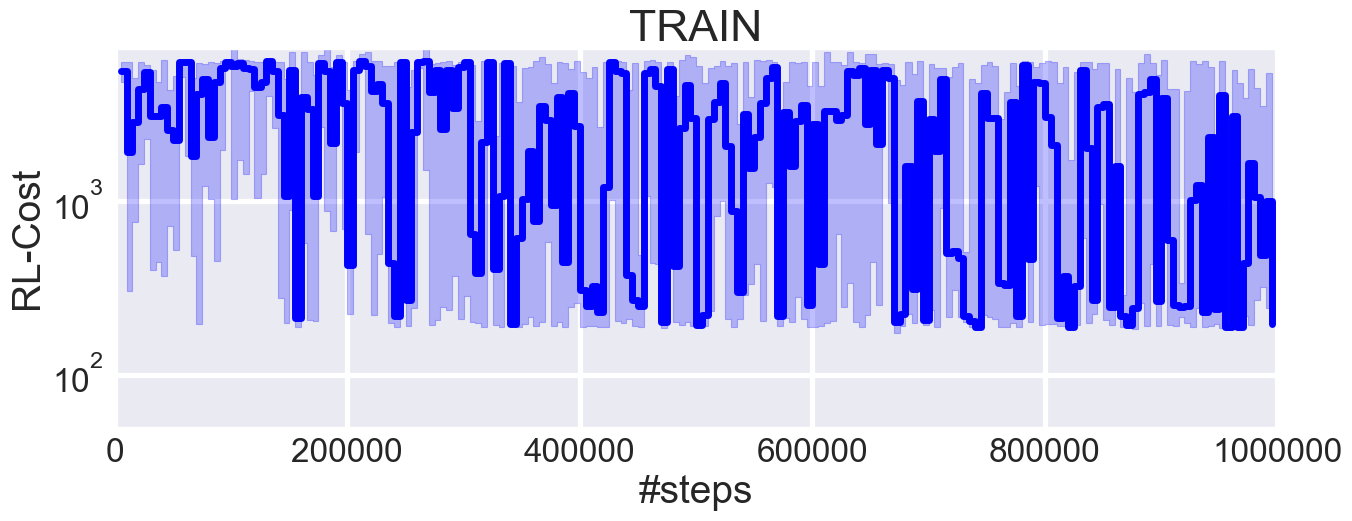



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_3_full_train_set_2-75-1-split3
################################################################################


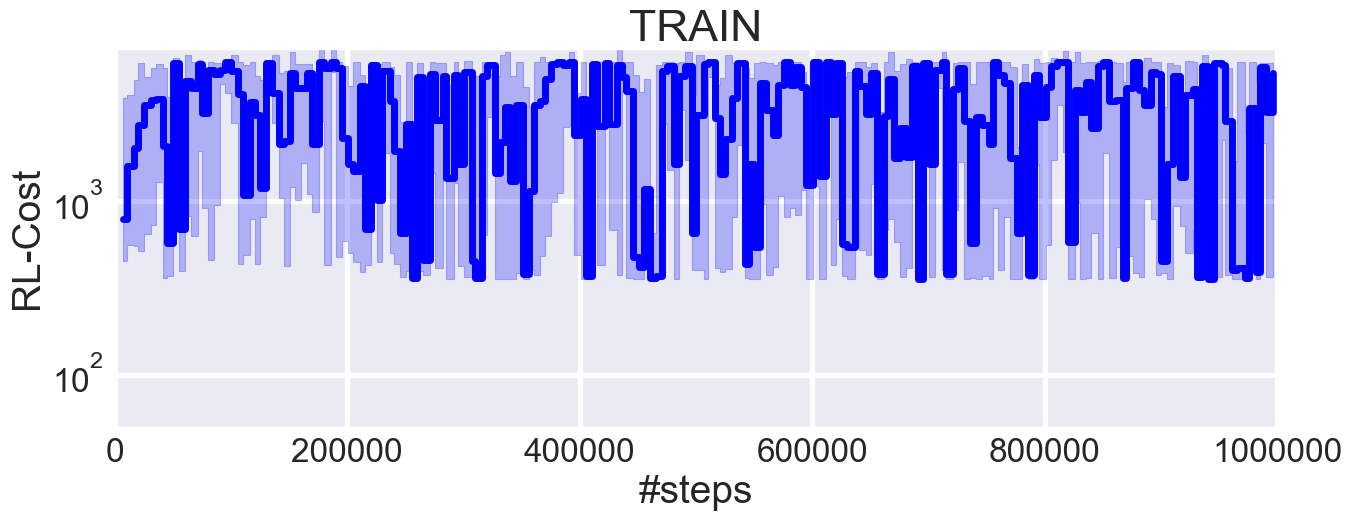



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_3_full_train_set_2-200-1-split3
################################################################################


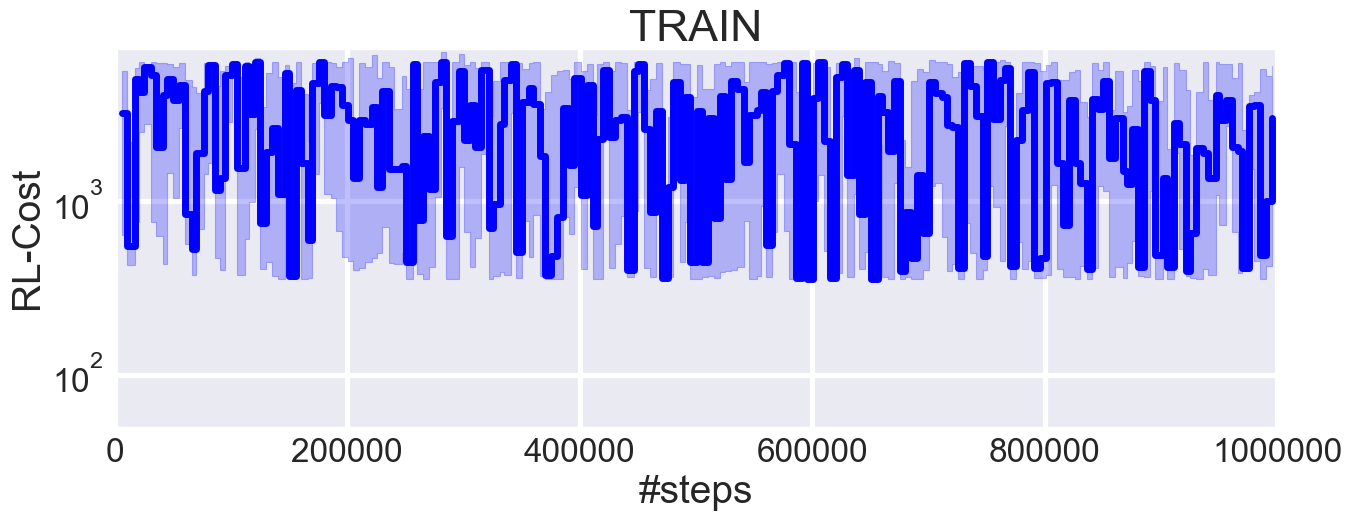



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_4_full_train_set_2-75-1-split4
################################################################################


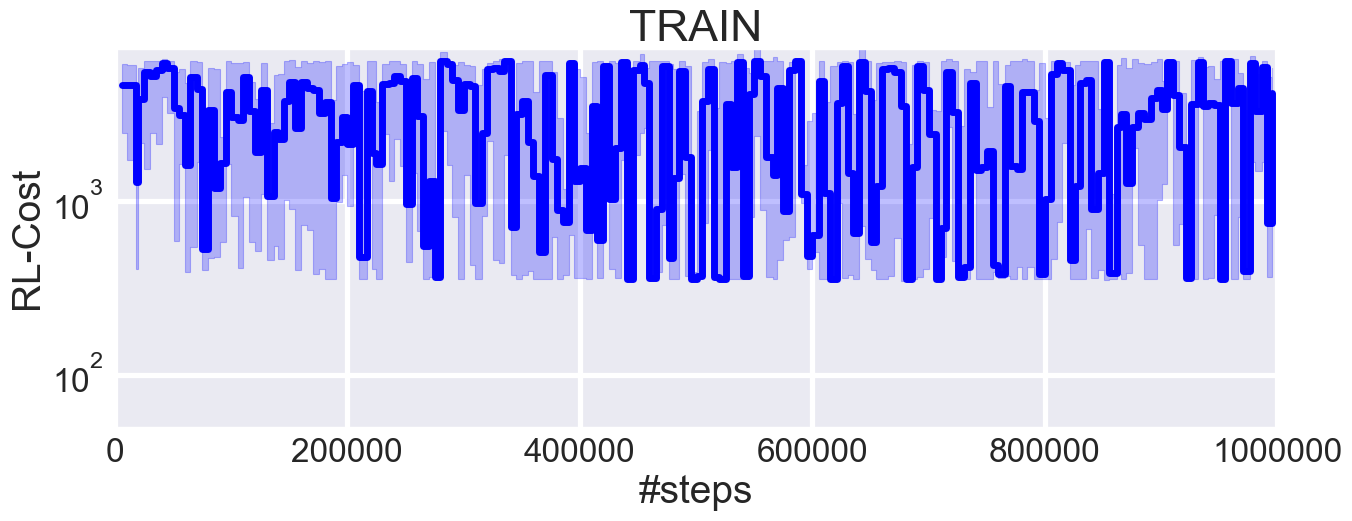



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_4_full_train_set_2-200-1-split4
################################################################################


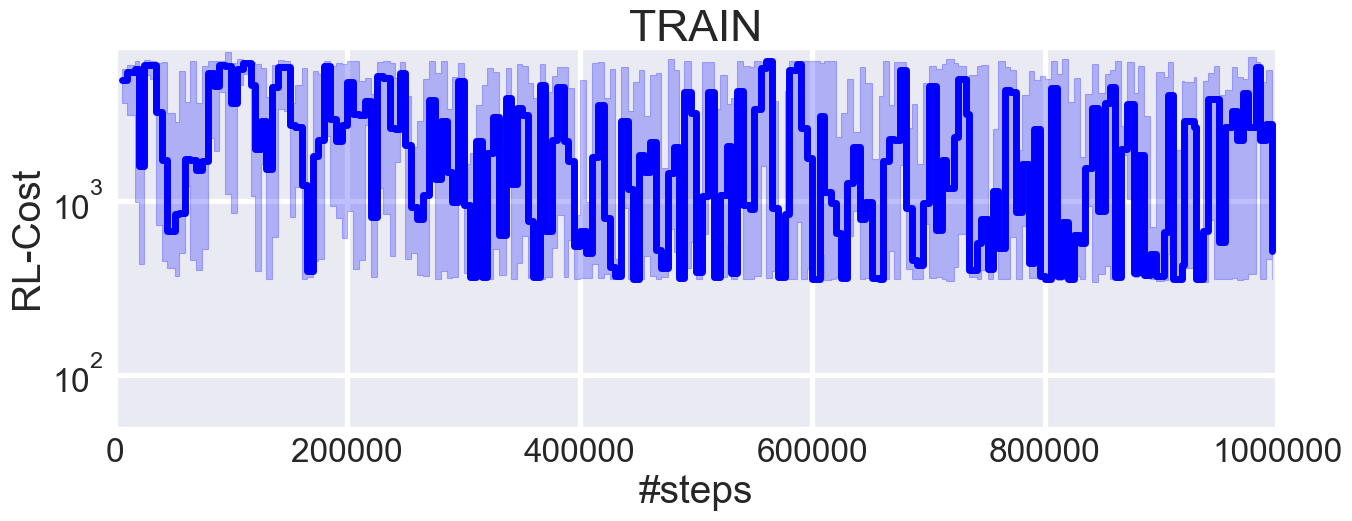



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_5_full_train_set_2-75-1-split5
################################################################################


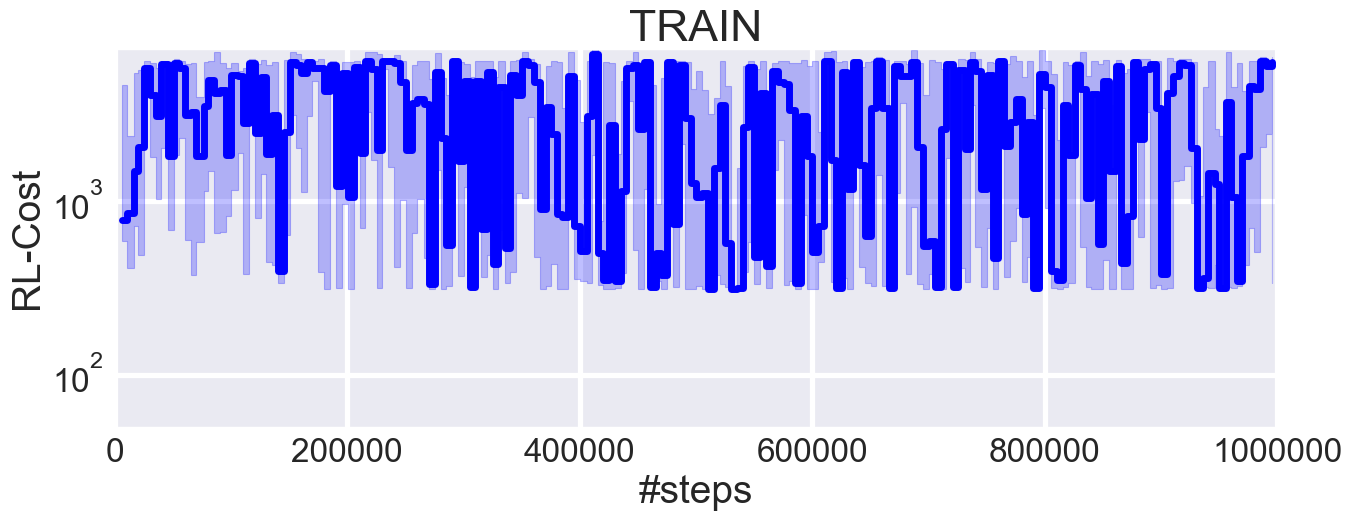



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_5_full_train_set_2-200-1-split5
################################################################################


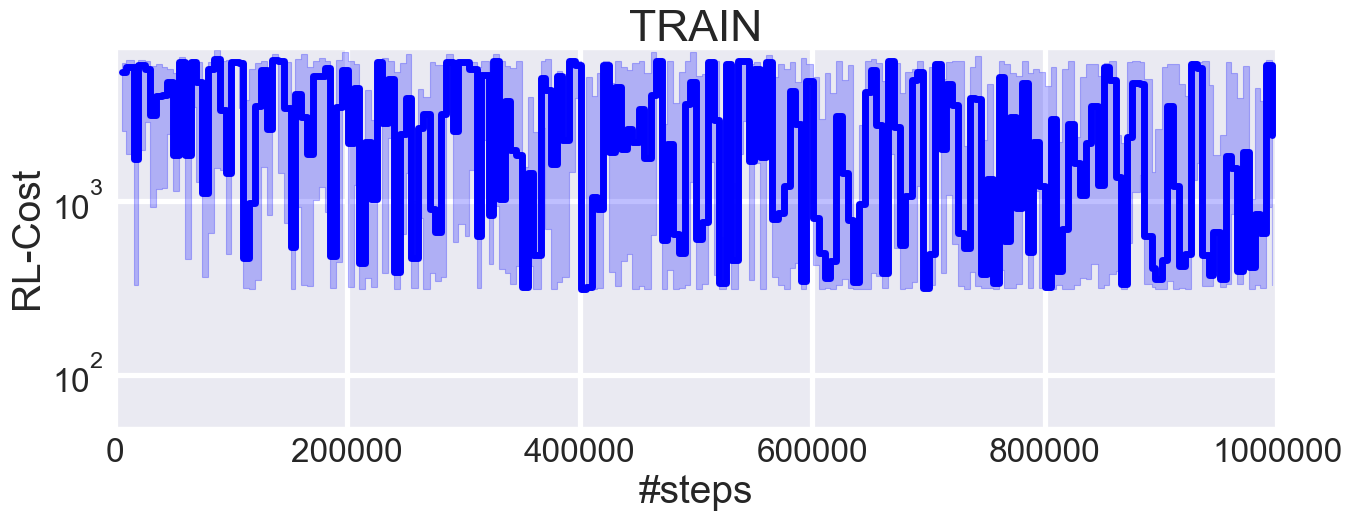



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [9]:
##### Plots using Quartiles
plot_means(plot_bsf=False, old=True, lay=[2], uni=[75, 200],
           exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], quantile=True,
           splits=[1,2,3,4,5], medi=False, local=False, assembly_version=3)

<BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR><BR>
## Plotting individual runs
<BR>

#### OLD FEATS
##### Very Wide Nets

No handles with labels found to put in legend.


################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-75-1-split1
################################################################################
Final learned 326.0833333333333
Final learned 325.0833333333333
Final learned 327.8333333333333
Final learned 311.375
Final learned 329.7916666666667
Final learned 339.5
Final learned 321.0416666666667
Final learned 328.7083333333333
Final learned 322.25
Final learned 325.6666666666667


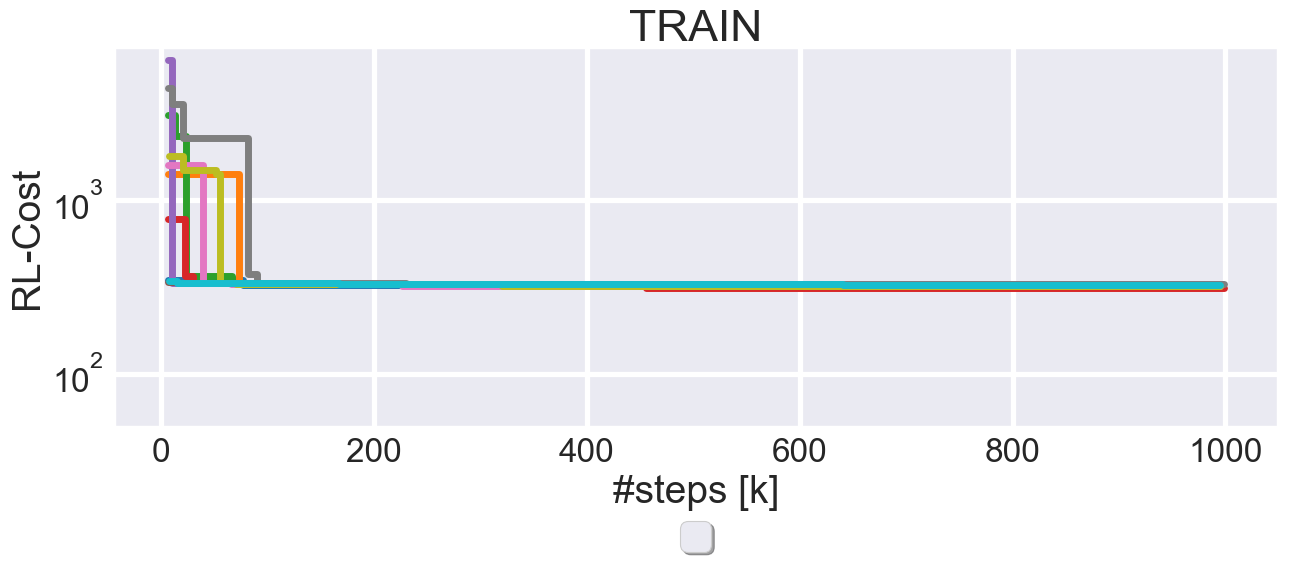

No handles with labels found to put in legend.




################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-200-1-split1
################################################################################
Final learned 320.3333333333333
Final learned 325.2916666666667
Final learned 312.0416666666667
Final learned 325.625
Final learned 317.5
Final learned 315.0833333333333
Final learned 309.8333333333333
Final learned 305.4583333333333
Final learned 220.20833333333331
Final learned 327.125


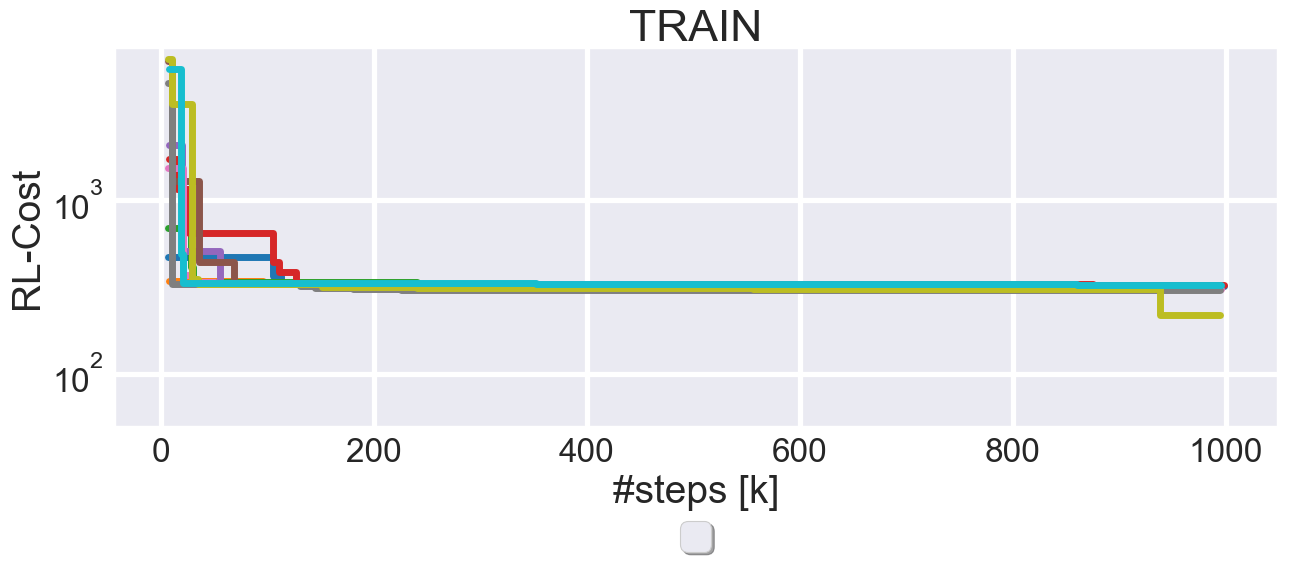

No handles with labels found to put in legend.




################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_2_full_train_set_2-75-1-split2
################################################################################
Final learned 171.83333333333337
Final learned 167.875
Final learned 174.58333333333337
Final learned 172.95833333333337
Final learned 180.75
Final learned 175.75
Final learned 179.875
Final learned 184.16666666666663
Final learned 186.33333333333331
Final learned 167.79166666666666


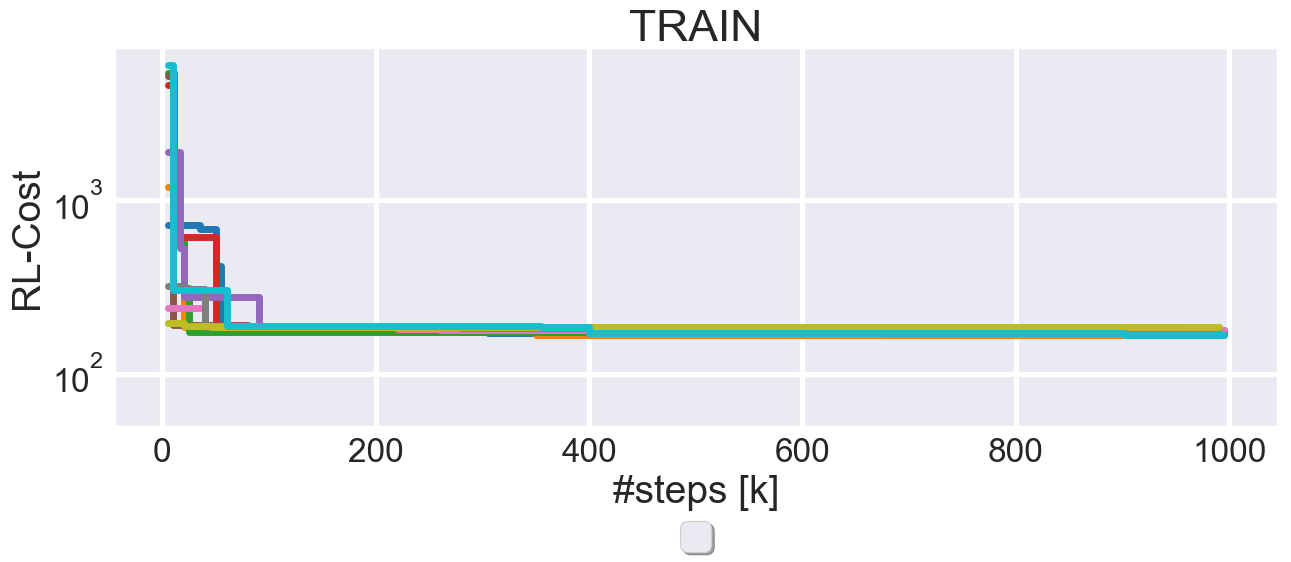

No handles with labels found to put in legend.




################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_2_full_train_set_2-200-1-split2
################################################################################
Final learned 165.54166666666666
Final learned 173.08333333333337
Final learned 156.54166666666666
Final learned 159.79166666666666
Final learned 171.91666666666663
Final learned 169.45833333333334
Final learned 174.54166666666663
Final learned 185.75
Final learned 167.54166666666666
Final learned 171.04166666666666


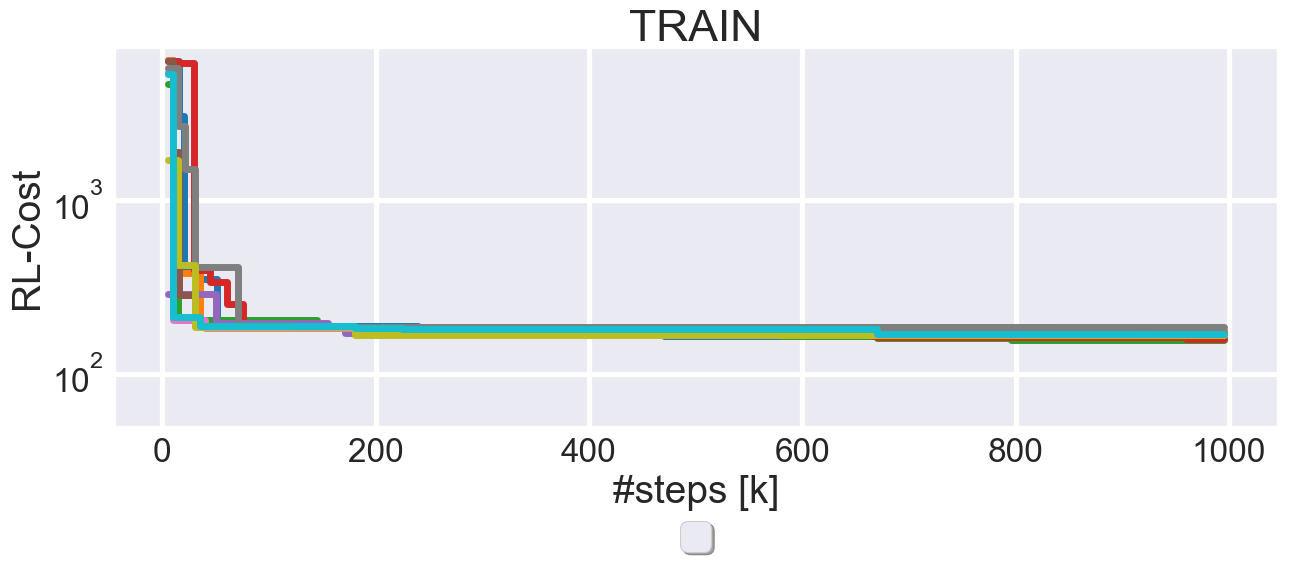

No handles with labels found to put in legend.




################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_3_full_train_set_2-75-1-split3
################################################################################
Final learned 352.04166666666674
Final learned 329.875
Final learned 347.66666666666674
Final learned 345.125
Final learned 352.79166666666674
Final learned 345.91666666666674
Final learned 341.625
Final learned 339.3333333333333
Final learned 272.875
Final learned 332.0833333333333


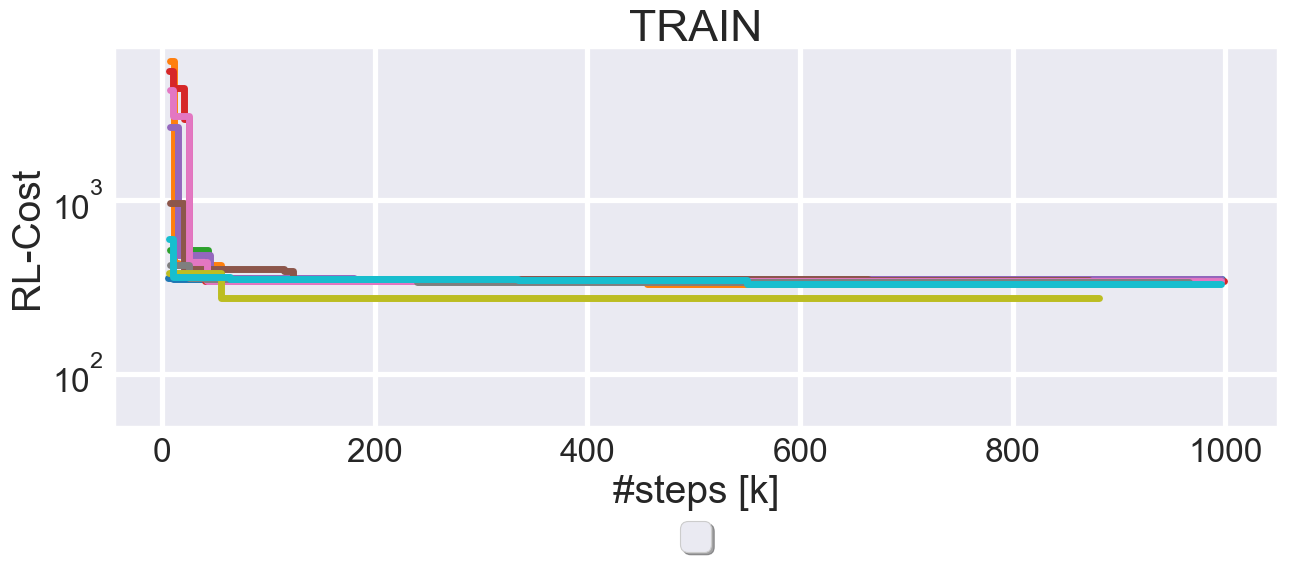

No handles with labels found to put in legend.




################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_3_full_train_set_2-200-1-split3
################################################################################
Final learned 349.91666666666674
Final learned 349.75
Final learned 330.9166666666667
Final learned 340.9583333333333
Final learned 340.8333333333333
Final learned 345.45833333333326
Final learned 322.5
Final learned 349.54166666666674
Final learned 339.5
Final learned 347.45833333333326


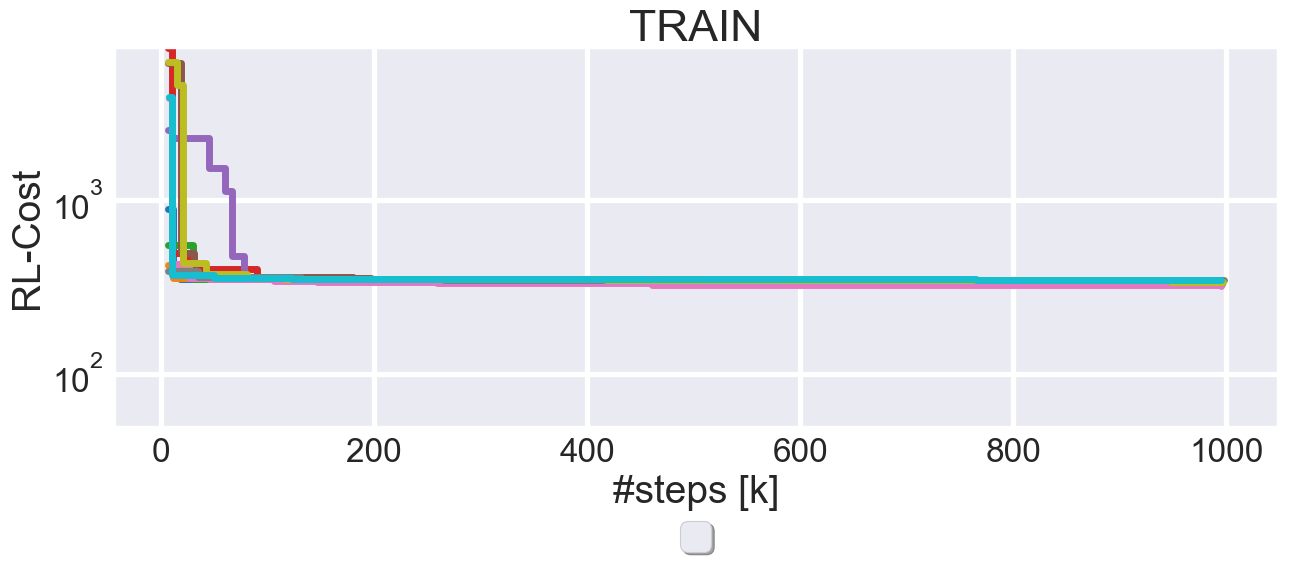



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_4_full_train_set_2-75-1-split4
################################################################################
Final learned 329.6666666666667
Final learned 336.4583333333333
Final learned 334.375
Final learned 205.45833333333331
Final learned 338.7916666666667
Final learned 331.5
Final learned 347.5
Final learned 332.0416666666667
Final learned 347.16666666666674


No handles with labels found to put in legend.


Final learned 335.625


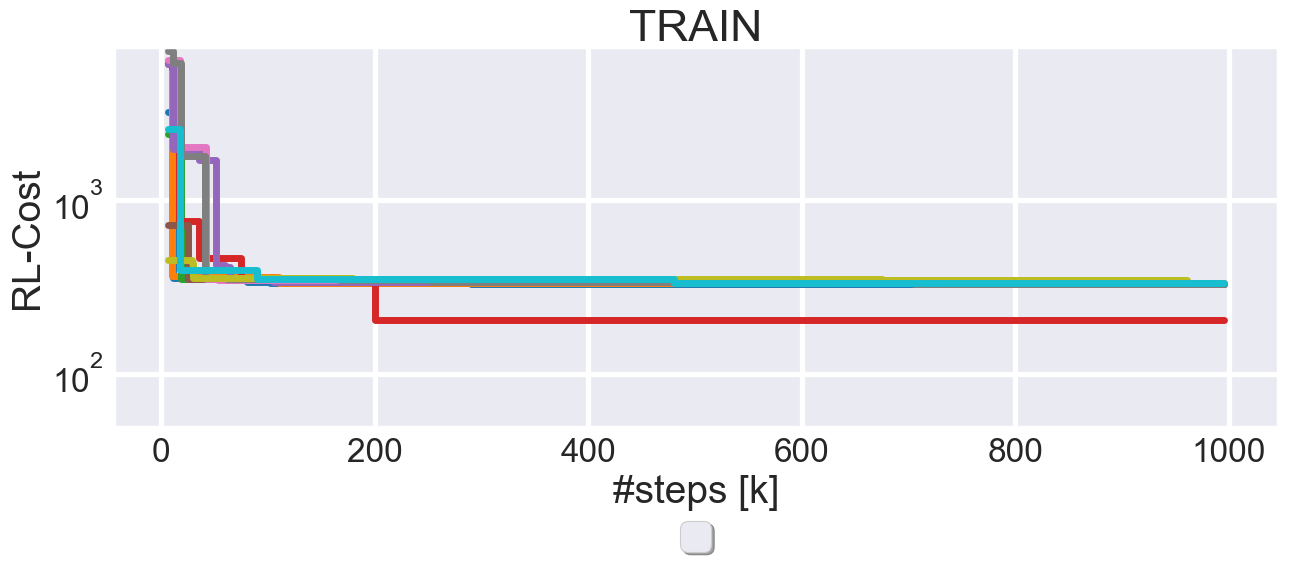



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_4_full_train_set_2-200-1-split4
################################################################################
Final learned 331.8333333333333
Final learned 328.75
Final learned 331.9583333333333
Final learned 329.4166666666667
Final learned 322.9166666666667


No handles with labels found to put in legend.


Final learned 336.6666666666667
Final learned 330.0833333333333
Final learned 332.9166666666667
Final learned 327.4166666666667
Final learned 331.3333333333333


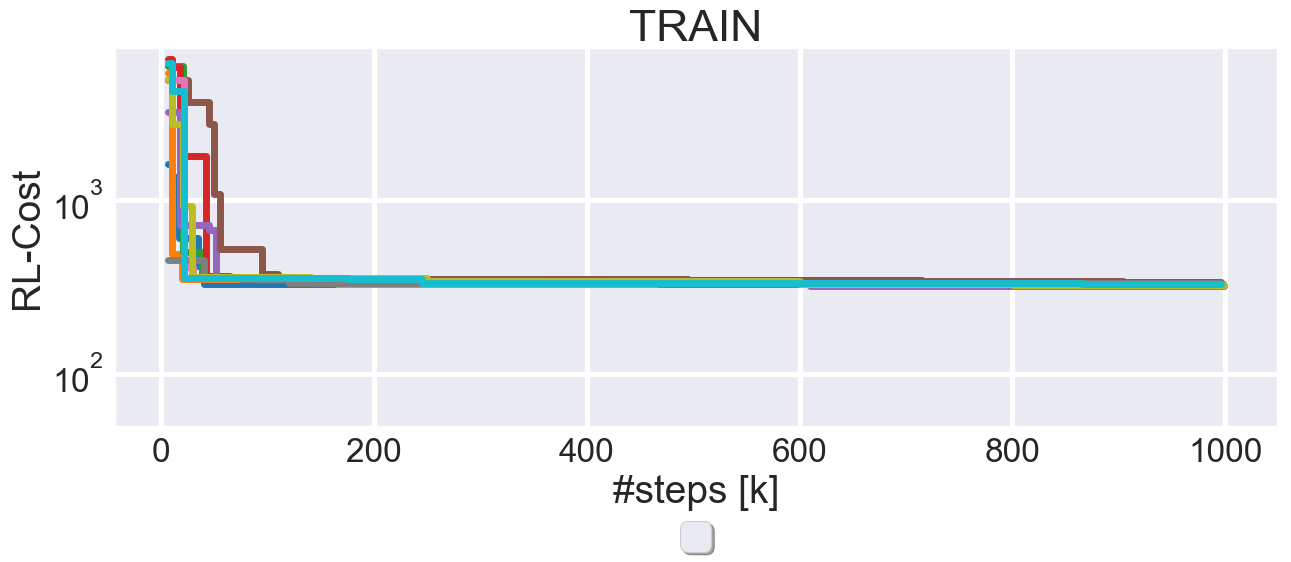

No handles with labels found to put in legend.




################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_5_full_train_set_2-75-1-split5
################################################################################
Final learned 308.9583333333333
Final learned 308.875
Final learned 308.25
Final learned 229.66666666666663
Final learned 306.1666666666667
Final learned 307.875
Final learned 307.7083333333333
Final learned 308.3333333333333
Final learned 310.0416666666667
Final learned 309.0416666666667


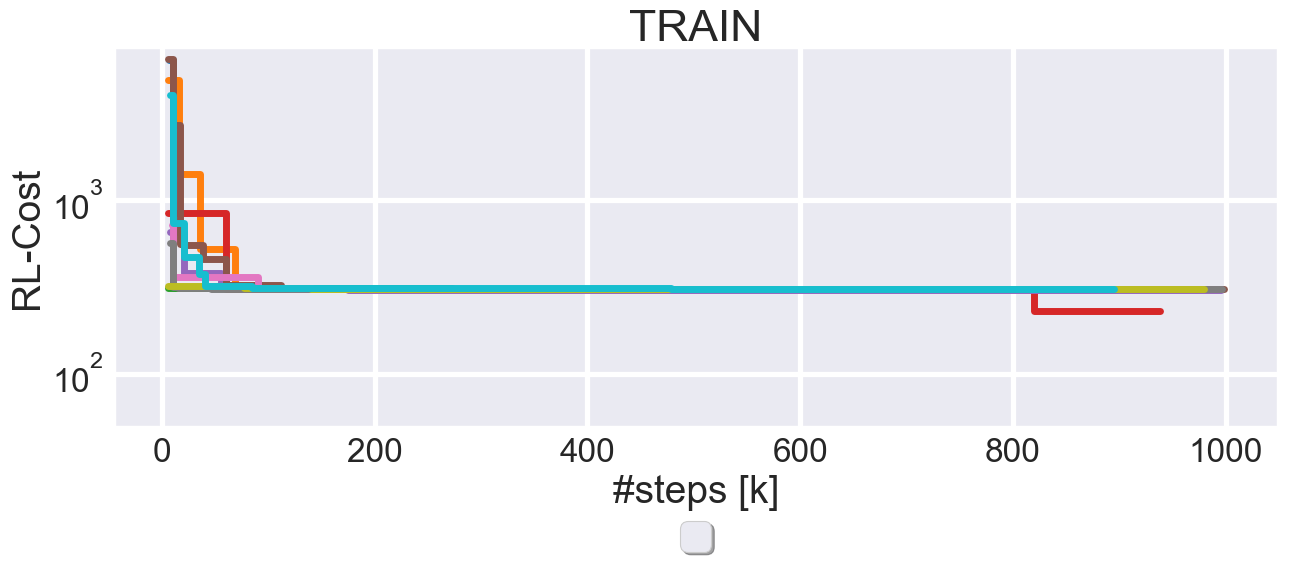

No handles with labels found to put in legend.




################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_5_full_train_set_2-200-1-split5
################################################################################
Final learned 306.375
Final learned 308.9166666666667
Final learned 307.25
Final learned 302.8333333333333
Final learned 309.0416666666667
Final learned 303.5
Final learned 307.0833333333333
Final learned 308.2916666666667
Final learned 304.9166666666667
Final learned 307.75


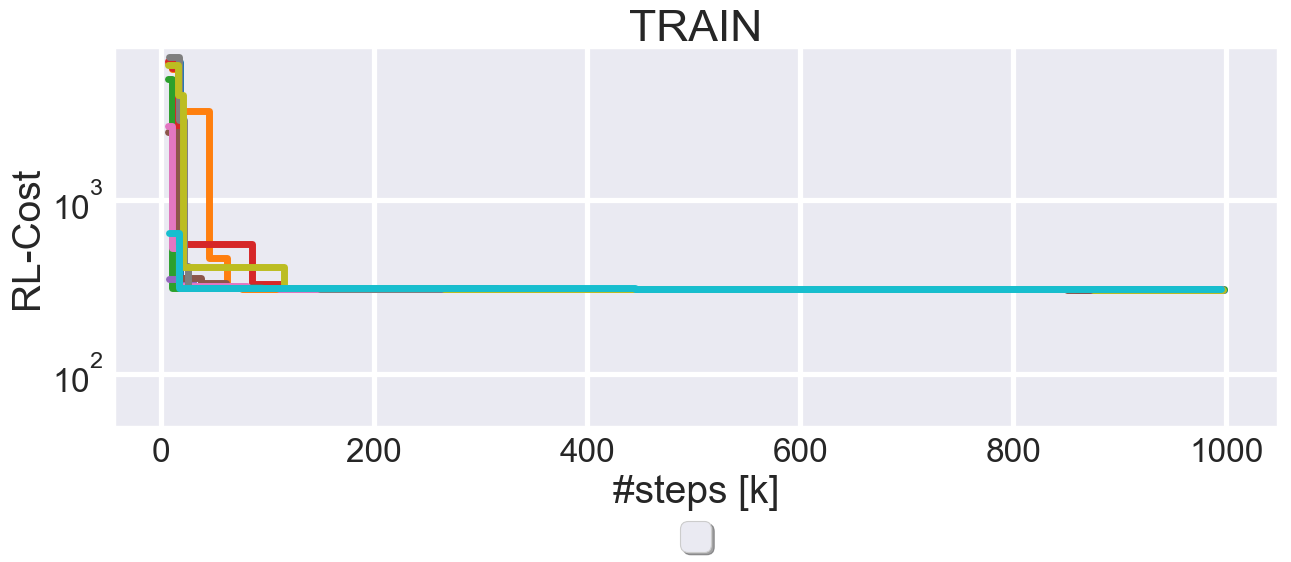

In [10]:
plot(old=True, lay=[2], uni=[75, 200],
     exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
           splits=[1,2,3,4,5], local=False, assembly_version=3)

################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-75-1-split1
################################################################################


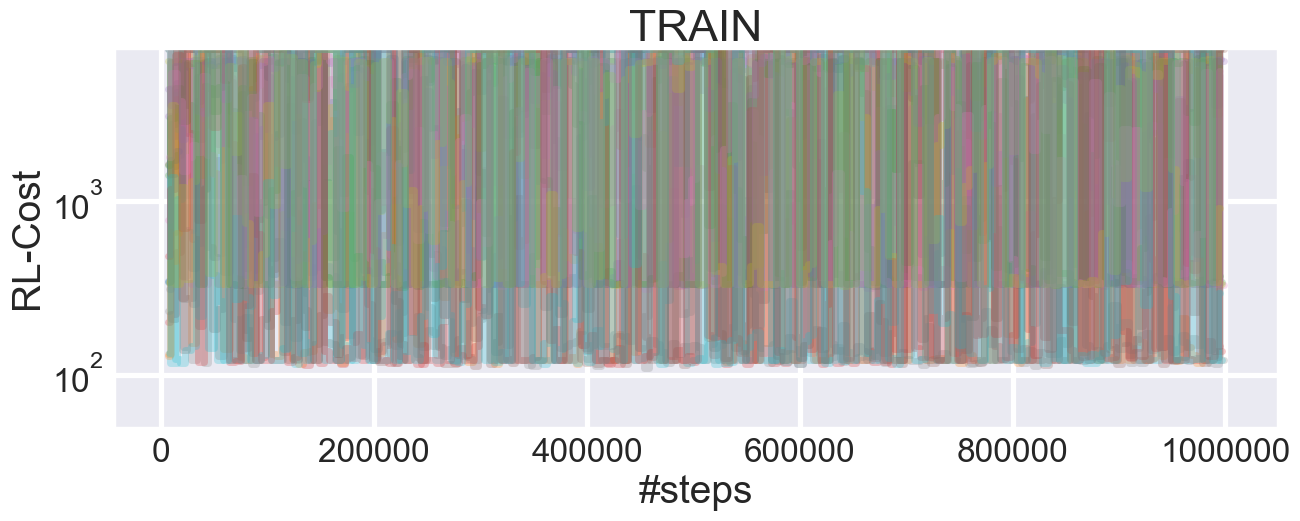



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_1_full_train_set_2-200-1-split1
################################################################################


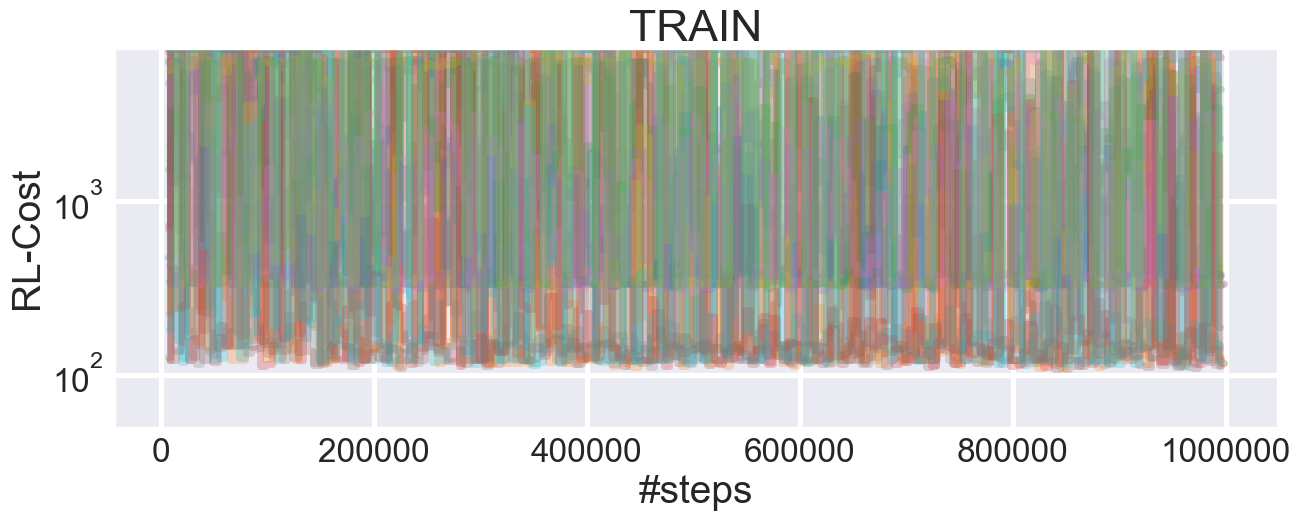



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_2_full_train_set_2-75-1-split2
################################################################################


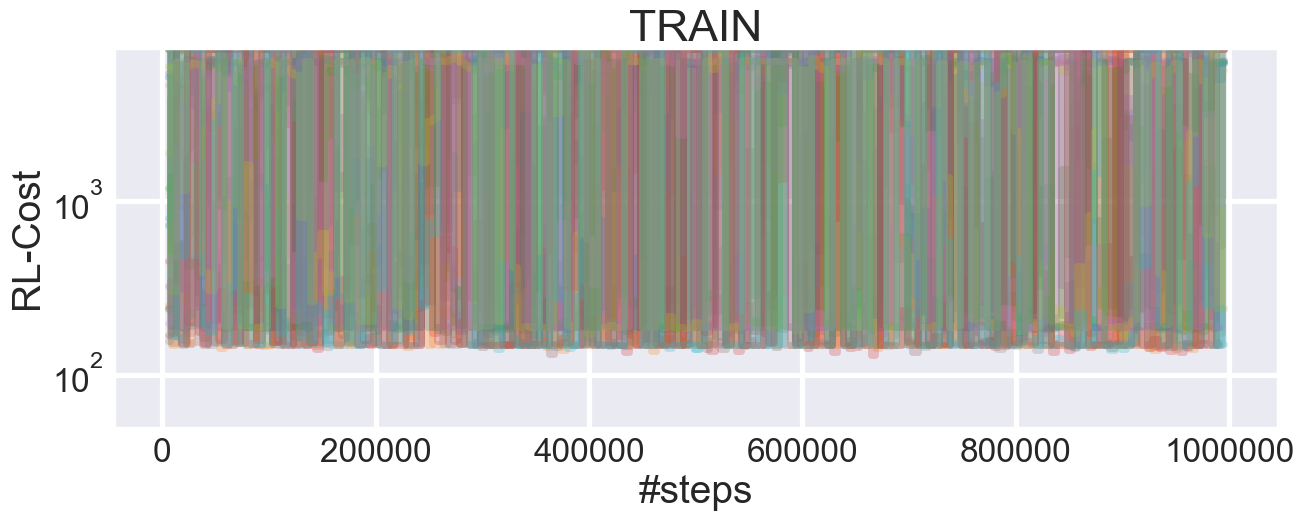



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_2_full_train_set_2-200-1-split2
################################################################################


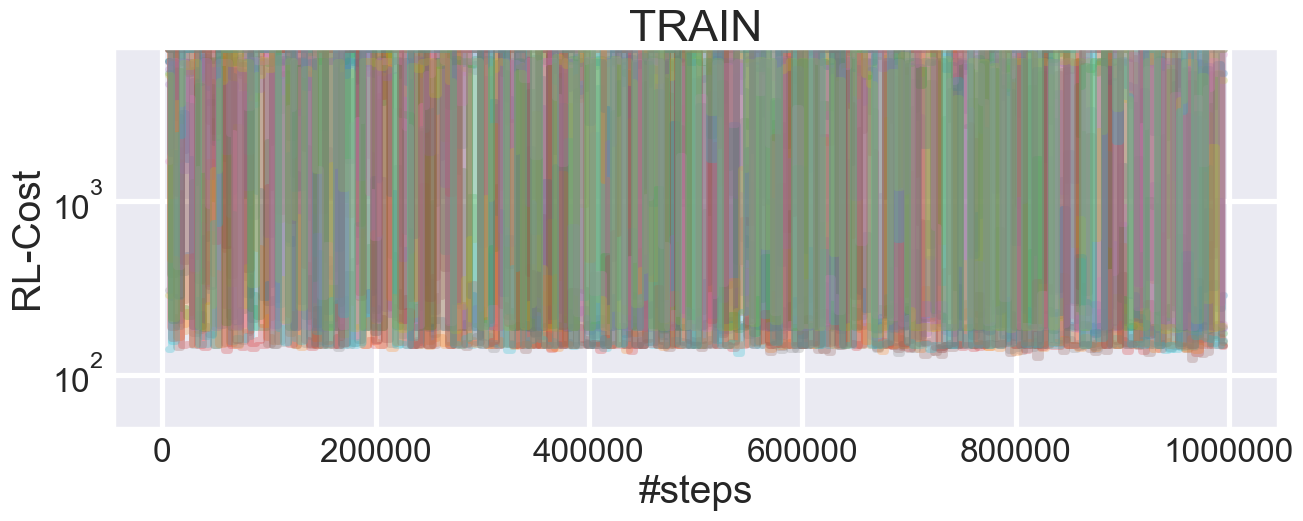



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_3_full_train_set_2-75-1-split3
################################################################################


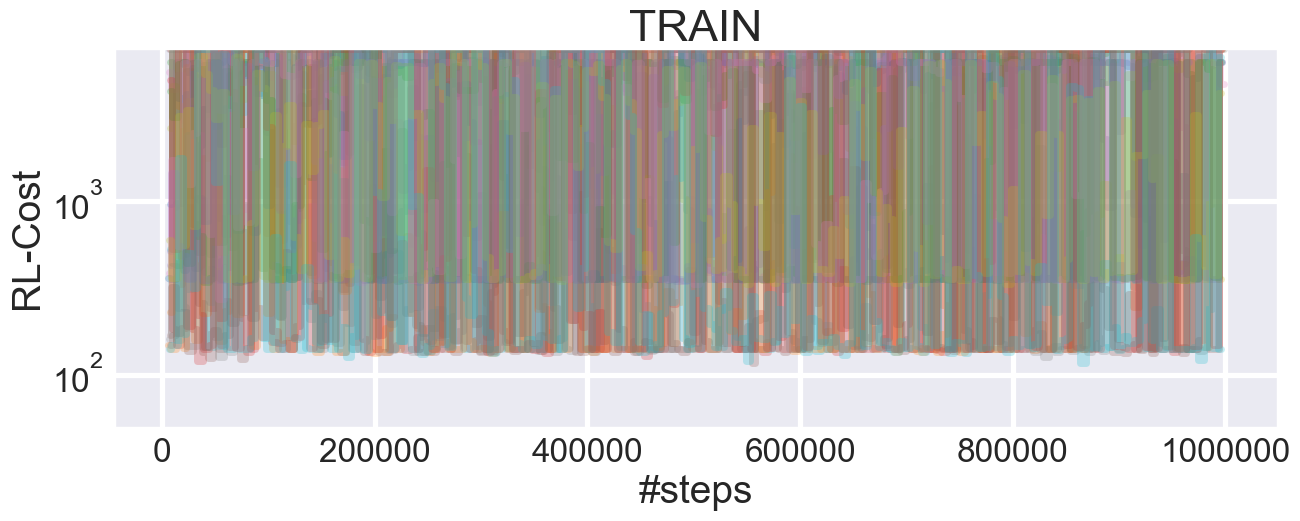



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_3_full_train_set_2-200-1-split3
################################################################################


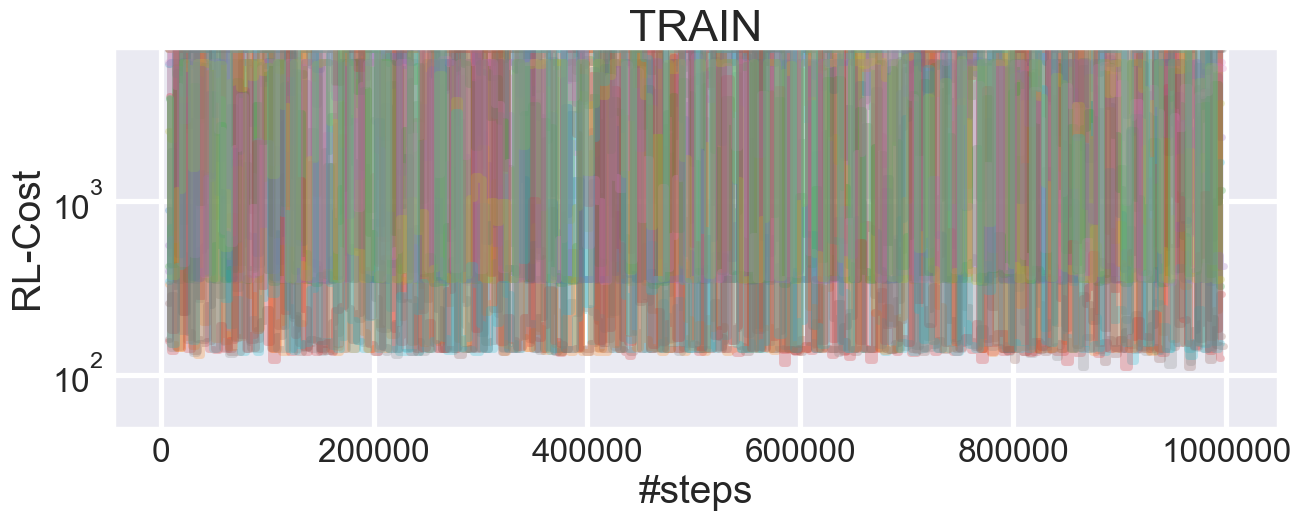



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_4_full_train_set_2-75-1-split4
################################################################################


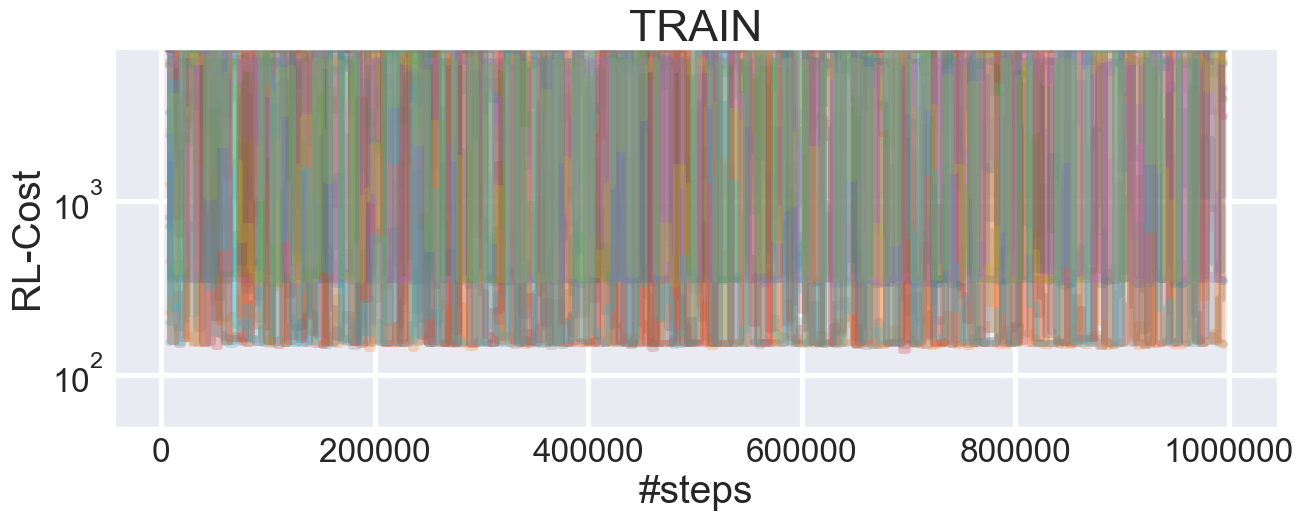



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_4_full_train_set_2-200-1-split4
################################################################################


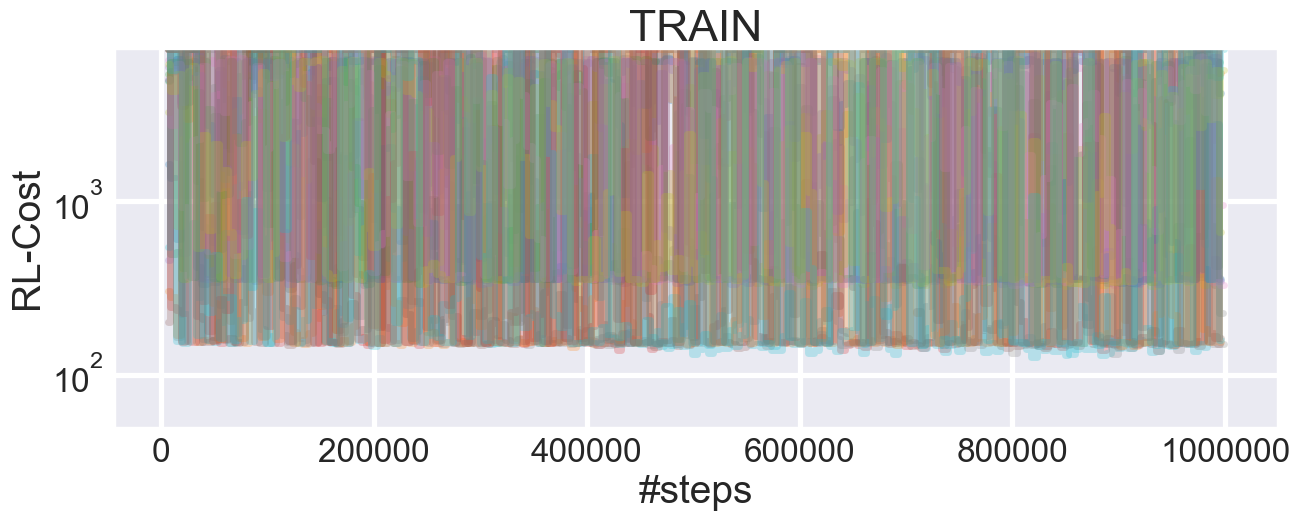



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_5_full_train_set_2-75-1-split5
################################################################################


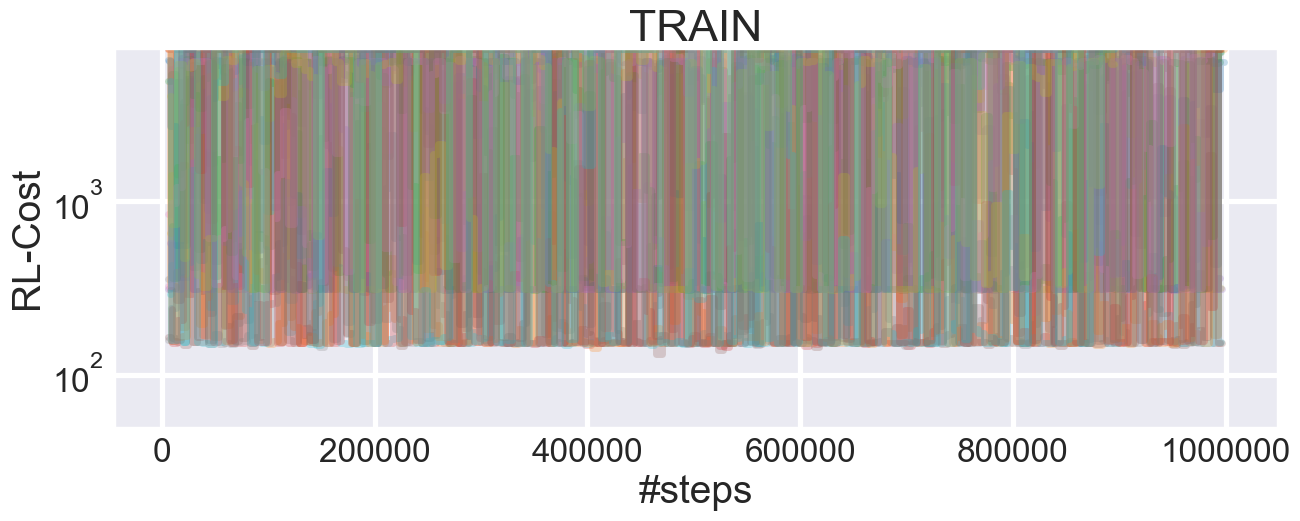



################################################################################
/mhome/biedenka/rl-plan-tmp/experiments/assembly_v3/old_feats_wide_long_5_full_train_set_2-200-1-split5
################################################################################


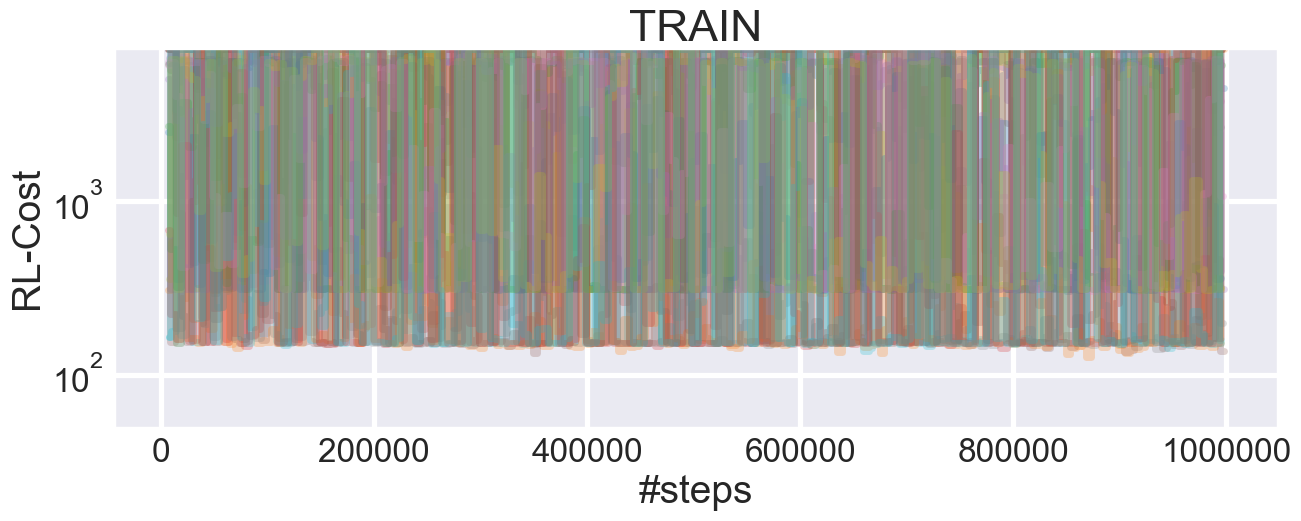

In [11]:
plot(plot_bsf=False, old=True, lay=[2], uni=[75, 200],
     exp=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
           splits=[1,2,3,4,5], local=False, assembly_version=3)